Link to the website: https://madsa2398.wixsite.com/collaboration-in-the

In [ ]:
!pip install gender_guesser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from ipywidgets import interact, widgets
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import math
from tqdm.notebook import tqdm
import json
from networkx.readwrite import json_graph
import networkx as nx 
from networkx.algorithms.assortativity import attribute_assortativity_coefficient
import gender_guesser.detector as gender
from scipy.stats import mannwhitneyu
from scipy import stats
from datetime import datetime
import random
from community import community_louvain
from scipy.stats import t
from collections import defaultdict
from PIL import Image
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Setting up paths and directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/CSS-final-project/'

/content/drive/MyDrive/CSS-final-project


In [ ]:
#Mads - adding the drive from my directory
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Computational Social Science/CSS-final-project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/17DyAw2PnZYvCDhy_UqXoeeIuSVFL2PFl/CSS-final-project


In [ ]:
sns.set_theme(style="whitegrid")

# Project Assignment B:
# **Studying patterns of collaboration within the movie industry**


## Statement of Collaboration

Group Members:
* Mads Andersen: s204137 - Graph construction & Network analysis
* Marton Kohegyi: s230086 - Community analysis & Visualisations
* Vidisha Sinha: s204081 - Text analysis & Preliminary analysis 

##### Contribution statement
We have worked on all parts together, but the main responsibility for adding the code and descriptions are stated next to the names.

# Introduction

This project aims to explore the patterns of collaboration within the movie industry from the perspectives of genre, review scores, and gender. To achieve this goal, the network of movies connected by actors and the communities that form within this network are analyzed using statistical measures like assortativity, ... . Additionally, the  of the graph concerning different variables will be studied to identify possible biases and tendencies. 

There is text analysis performed on the reviews that occur in different communities. This analysis is performed using techniques like WordClouds and TF-IDF statistics, and is used to study similarities and differences between communities. These top descriptive terms from various communities are then compared to descriptive terms from reviews differentiated by genre, review score, and gender of the actor. This will aid understanding on whether movie communities are largely separated by any of these factors.

This study is interesting as it analyzes collaboration patterns within the movie industry and the communities that form within it, while also exploring the impact of factors like genre, review scores, and gender on reviews and the sucess of a movie. These findings can have significant implications for the industry, highlighting potential areas of improvement and ways to better promote collaboration.

# Overview of the dataset

This section gives a detailed overview of the data used. Conducting this study required information about movies, actors, review scores, reviews, and gender of the actors. This data was assembled by combining two datasets - *rotten_tomatoes_critic_reviews* and *rotten_tomatoes_movies* available on Kaggle. As these datasets did not contain information about the gender of the actors, the GenderGuesser API was also used.

In [ ]:
# Importing the 'rotten_tomatoes_critic_reviews' dataset
df_ = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

# Importing the 'rotten_tomatoes_movies' dataset
pf_ = pd.read_csv('rotten_tomatoes_movies.csv')

## Describing *rotten_tomatoes_critic_reviews* dataset

The dataset *rotten_tomatoes_critic_reviews* comprises approximately one million reviews from critics for various movies in *rotten_tomatoes_movies*. It consists of eight features that include:

1. "rotten_tomatoes_link" which contains a link corresponding to a movie in "rotten_tomatoes_movies".
2. "critic_name" which indicates the name of the critic who wrote the review.
3. "top_critic" which is a boolean value indicating if the critic is considered a top critic.
4. "publisher_name" which contains the name of the publisher who published the review.
5. "review_type" which can be either "Fresh" or "Rotten", indicating whether the review is positive or negative, respectively.
6. "review_score" which displays the score given to the movie by the critic.
7. "review_date" which shows the date when the review was published.
8. "review_content" which contains the content of the review.

To ensure data accuracy, duplicate rows in this dataset were removed using Pandas' `drop_duplicates()` function.

In [ ]:
df = df_.drop_duplicates()
print(f'Initial shape of rotten_tomatoes_critics_reviews is : {df_.shape}')
print(f'Final shape of rotten_tomatoes_critics_reviews is : {df.shape}')
print(f'Number of columns dropped = {df_.shape[0]-df.shape[0]} \n')
df.head()

Initial shape of rotten_tomatoes_critics_reviews is : (1130017, 8)
Final shape of rotten_tomatoes_critics_reviews is : (1010546, 8)
Number of columns dropped = 119471 



rotten_tomatoes_link      critic_name  top_critic           publisher_name  \
0            m/0814255  Andrew L. Urban       False           Urban Cinefile   
1            m/0814255    Louise Keller       False           Urban Cinefile   
2            m/0814255              NaN       False      FILMINK (Australia)   
3            m/0814255     Ben McEachen       False  Sunday Mail (Australia)   
4            m/0814255      Ethan Alter        True       Hollywood Reporter   

  review_type review_score review_date  \
0       Fresh          NaN  2010-02-06   
1       Fresh          NaN  2010-02-06   
2       Fresh          NaN  2010-02-09   
3       Fresh        3.5/5  2010-02-09   
4      Rotten          NaN  2010-02-10   

                                      review_content  
0  A fantasy adventure that fuses Greek mythology...  
1  Uma Thurman as Medusa, the gorgon with a coiff...  
2  With a top-notch cast and dazzling special eff...  
3  Whether audiences will get behind The Lightnin...  
4  What's really lacking in The Lightning Thief i...

Only features "critic_name", "review_score", and "review_content" contain missing values which will need to be taken into account while doing further analysis. The largest number of missing values exist in "review_score", where 27.1\% of the data is missing.

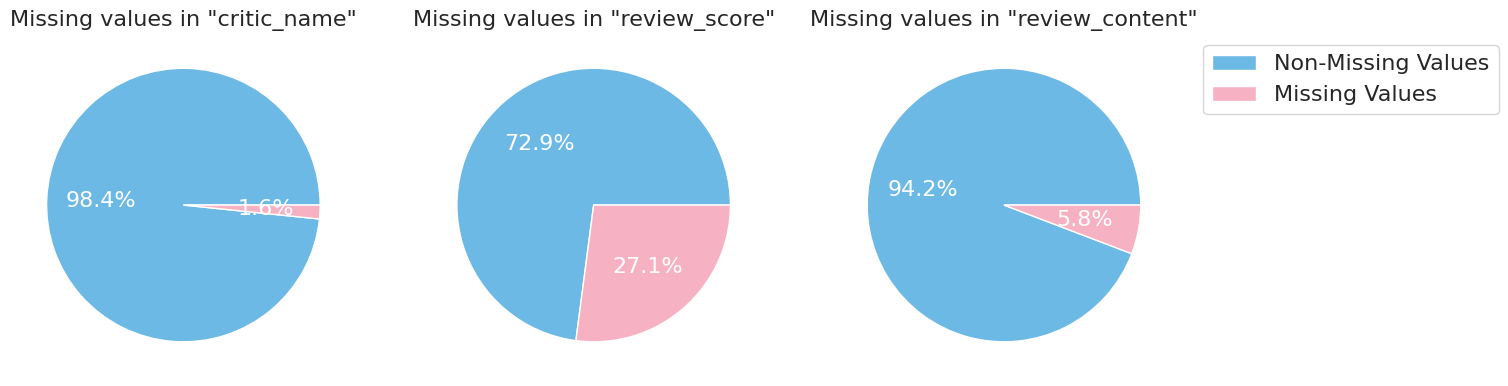

In [ ]:
def missing_vals_pie_chart(df):
  # Calculate the number of missing values for each column
  missing_values = df.isnull().sum()

  # Find columns with nan values
  nan_columns = df.isnull().any()
  columns = nan_columns[nan_columns == True].index.tolist()

  # Create subplots for each column
  fig, axs = plt.subplots(ncols=len(columns), figsize=(15,5))

  for i, col in enumerate(columns):
      # Calculate the total number of values for the column
      total_values = len(df[col])
      
      # Calculate the number of non-missing values
      non_missing_values = total_values - missing_values[col]
      
      # Create the pie charts
      wedges, texts, autotexts = axs[i].pie([non_missing_values, missing_values[col]], colors=['#6db9e6', '#f6b1c3'], autopct='%1.1f%%')
      axs[i].set_title(f'Missing values in "{col}"',fontsize=16)
      for autotext in autotexts:
          autotext.set_color('white')
          autotext.set_fontsize(16)

  plt.legend(['Non-Missing Values', 'Missing Values'], bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
  plt.show()

missing_vals_pie_chart(df)

The rows without reviews are dropped as they are of no use. This leaves the dataset with a little less than a million reviews to analyse. 

In [ ]:
df = df.dropna(subset=['review_content'])
print(f'Number of rows left: {df.shape[0]}')

Number of rows left: 952020


There are around 11,000 unique critics in the dataset and 2,000 unique publishers.

In [ ]:
print(f'Number of unique critics: {df["critic_name"].nunique()}')
print(f'Number of unique publishers: {df["publisher_name"].nunique()}')

Number of unique critics: 11073
Number of unique publishers: 2229


Finally, it is found that approximately 25.6\% of the critics in the dataset are considered 'top critics'. Also, 63.7\% of the remaining reviews are considered 'fresh', while 36.3\% are considered rotten.

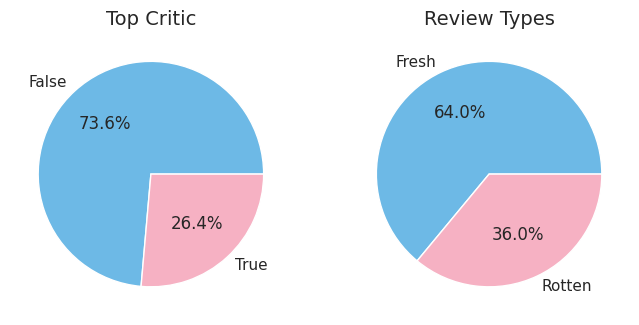

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

top_critic_counts = df['top_critic'].value_counts()
axs[0].pie(top_critic_counts, labels=top_critic_counts.index, autopct='%1.1f%%', colors=['#6db9e6', '#f6b1c3'])
axs[0].set_title('Top Critic', fontsize=14)

review_type_counts = df['review_type'].value_counts()
axs[1].pie(review_type_counts, labels=review_type_counts.index, autopct='%1.1f%%', colors=['#6db9e6', '#f6b1c3'])
axs[1].set_title('Review Types', fontsize=14)

plt.show()

## Describing *rotten_tomatoes_movies* dataset

The *rotten_tomatoes_movies* dataset contains information about around 18,000 movies. Some of the interesting features present in the dataset include:

1. "rotten_tomatoes_link" which contains the movie link that corresponds to reviews in *rotten_tomatoes_critic_reviews*
2. "movie_title" which has the name of the movie
3. "movie_info" which contains the summary of the movie
4. "critics_consensus" which contains the summary of reviews by critics
5. "content_rating" which contains information about the rating of the movie
6. "genres" which contains the genres the movie is associated with
7. "directors" which contains the directors in the movie
8. "actors" which contains the actors in the movie
9. "production_company" which contains the name of the production company which produced the movie

There are no duplicates present in the dataset.

In [ ]:
pf = pf_.drop_duplicates()
print(f'Initial shape of rotten_tomatoes_critics_reviews is : {pf_.shape}')
print(f'Final shape of rotten_tomatoes_critics_reviews is : {pf.shape}')
print(f'Number of columns dropped = {pf_.shape[0]-pf.shape[0]} \n')
print(f'Columns: {pf.columns.to_list()} \n')
pf[:2]

Initial shape of rotten_tomatoes_critics_reviews is : (17712, 22)
Final shape of rotten_tomatoes_critics_reviews is : (17712, 22)
Number of columns dropped = 0 

Columns: ['rotten_tomatoes_link', 'movie_title', 'movie_info', 'critics_consensus', 'content_rating', 'genres', 'directors', 'authors', 'actors', 'original_release_date', 'streaming_release_date', 'runtime', 'production_company', 'tomatometer_status', 'tomatometer_rating', 'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'] 



rotten_tomatoes_link                                        movie_title  \
0            m/0814255  Percy Jackson & the Olympians: The Lightning T...   
1            m/0878835                                        Please Give   

                                          movie_info  \
0  Always trouble-prone, the life of teenager Per...   
1  Kate (Catherine Keener) and her husband Alex (...   

                                   critics_consensus content_rating  \
0  Though it may seem like just another Harry Pot...             PG   
1  Nicole Holofcener's newest might seem slight i...              R   

                                              genres          directors  \
0  Action & Adventure, Comedy, Drama, Science Fic...     Chris Columbus   
1                                             Comedy  Nicole Holofcener   

                                      authors  \
0  Craig Titley, Chris Columbus, Rick Riordan   
1                           Nicole Holofcener   

                                              actors original_release_date  \
0  Logan Lerman, Brandon T. Jackson, Alexandra Da...            2010-02-12   
1  Catherine Keener, Amanda Peet, Oliver Platt, R...            2010-04-30   

   ...      production_company  tomatometer_status tomatometer_rating  \
0  ...        20th Century Fox              Rotten               49.0   
1  ...  Sony Pictures Classics     Certified-Fresh               87.0   

  tomatometer_count  audience_status  audience_rating audience_count  \
0             149.0          Spilled             53.0       254421.0   
1             142.0          Upright             64.0        11574.0   

   tomatometer_top_critics_count  tomatometer_fresh_critics_count  \
0                             43                               73   
1                             44                              123   

   tomatometer_rotten_critics_count  
0                                76  
1                                19  

[2 rows x 22 columns]

A subset of columns is chosen to be analysed for missing values based on their relevance to this study. It can be seen that nearly half of the movies do not have a 'critic_consensus'. Both 'genres' and 'actors' has a low amount of missing values.

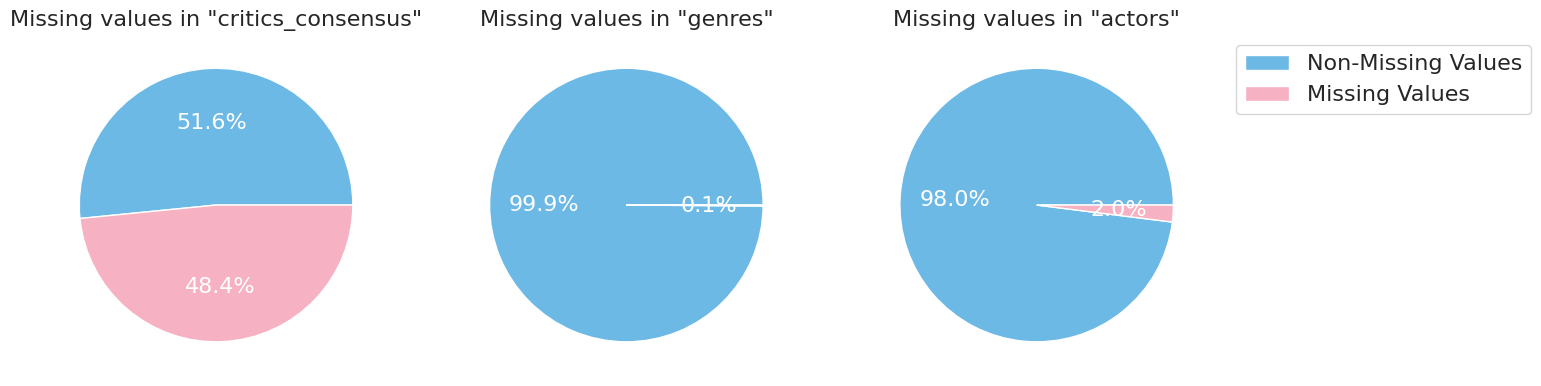

In [ ]:
pf_subset = pf[['rotten_tomatoes_link', 'movie_title', 'critics_consensus', 'genres','actors']]
missing_vals_pie_chart(pf_subset)

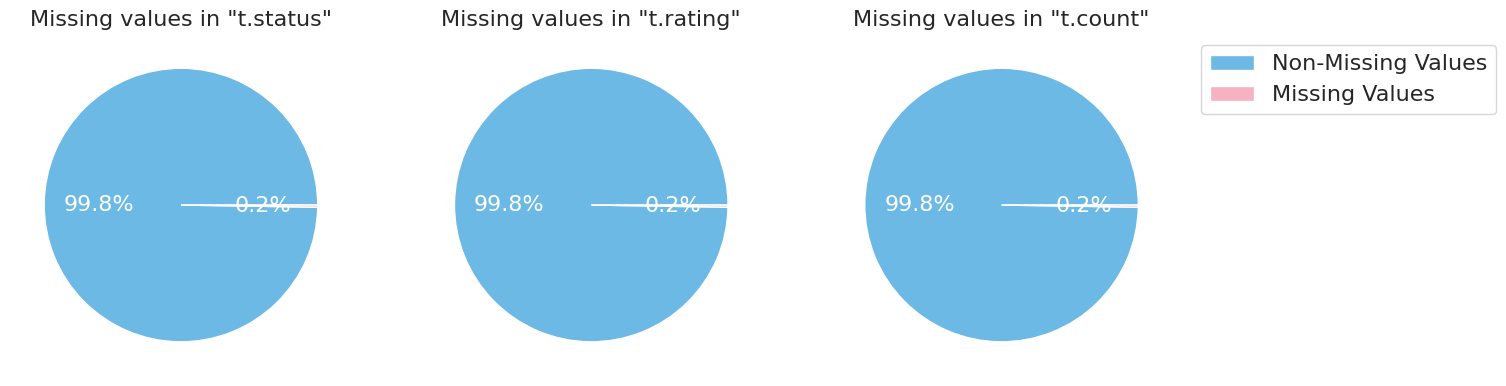

In [ ]:
pf_subset = pf[['tomatometer_status', 'tomatometer_rating', 'tomatometer_count']]
pf_subset.columns = ['t.status', 't.rating','t.count']
missing_vals_pie_chart(pf_subset)

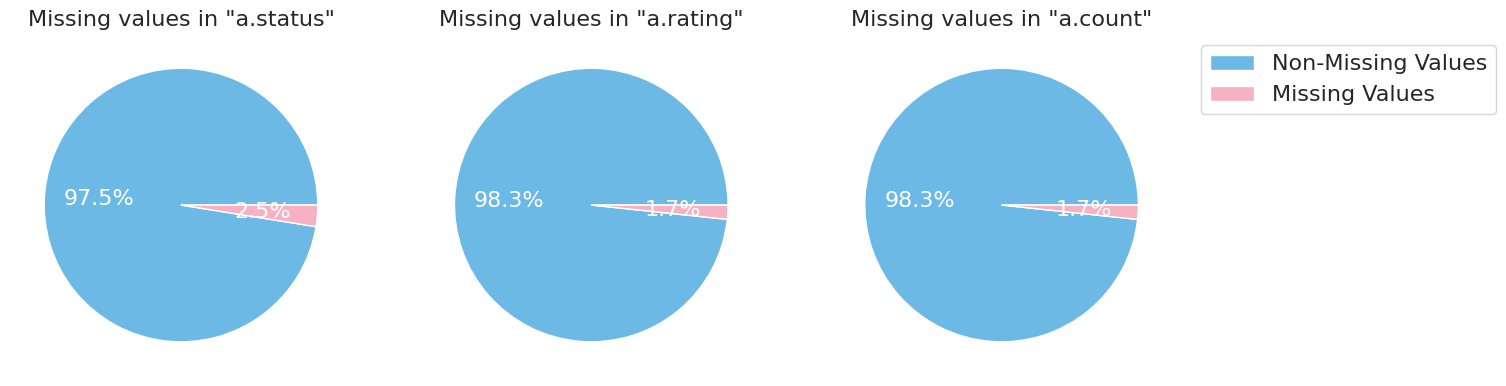

In [ ]:
pf_subset = pf[['audience_status', 'audience_rating', 'audience_count']]
pf_subset.columns = ['a.status', 'a.rating','a.count']
missing_vals_pie_chart(pf_subset)

In [ ]:
pf = pf.dropna(subset=['genres', 'actors', 'tomatometer_status', 'tomatometer_rating', 'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count'])

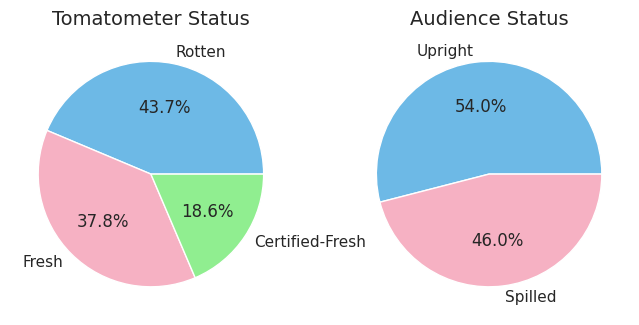

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

tomatometer_status = pf['tomatometer_status'].value_counts()
axs[0].pie(tomatometer_status, labels=tomatometer_status.index, autopct='%1.1f%%', colors=['#6db9e6', '#f6b1c3', 'lightgreen'])
axs[0].set_title('Tomatometer Status', fontsize=14)

audience_status = pf['audience_status'].value_counts()
axs[1].pie(audience_status, labels=audience_status.index, autopct='%1.1f%%', colors=['#6db9e6', '#f6b1c3','lightgreen'])
axs[1].set_title('Audience Status', fontsize=14)

plt.show()

The top 10 most occuring actors and genres are found as follows.

In [ ]:
def text_to_list(df, comm):
    df = df.copy()
    df[comm] = df[comm].str.lower().apply(lambda x: [elem.strip() for elem in re.split(',(?!\s*?jr\.)', x)])
    return df

In [ ]:
def top(df, comm,n_top=10):
  list_comm = text_to_list(df.dropna(subset=[comm]),comm)
  list_explode = list_comm.explode(comm, ignore_index=True)
  top_comm = list_explode[comm].value_counts().nlargest(n_top).index.to_list()
  print(f'Total {comm}: {list_explode[comm].nunique()}')
  return top_comm

In [ ]:
print(f"Top 10 genres: {top(pf,'genres')}\n")
print(f"Top 10 actors: {top(pf,'actors')}\n")

Total genres: 21
Top 10 genres: ['drama', 'comedy', 'action & adventure', 'mystery & suspense', 'art house & international', 'documentary', 'horror', 'romance', 'science fiction & fantasy', 'classics']

Total actors: 204123
Top 10 actors: ['samuel l. jackson', 'bruce willis', 'robert de niro', 'nicolas cage', 'steve buscemi', 'liam neeson', 'donald sutherland', 'harvey keitel', 'john goodman', 'willem dafoe']



In [ ]:
#Save for later use 
top_genres = top(pf,'genres',21)

Total genres: 21


## Guessing the gender
Now using the gender_guesser algorithm the gender of the actors can be found. By parsing the first name to the library the gender can be determined and it will output one of five classes: \{male,female,mostly_male,mostly_female, unknown,andy\} the last two means that the gender could not be determined. "unkown" means it could not be found in data-base and "andy" means equal probabillity. 

In [ ]:
#reviews = #pd.read_csv('rotten_tomatoes_critic_reviews.csv')
movies = pf_.copy() #pd.read_csv('rotten_tomatoes_movies.csv')
movies['original_release_date'] = pd.to_datetime(movies['original_release_date'])
movies['actors'] = movies['actors'].apply(lambda x: str(x).split(','))

### Adding the gender to the data-set
The gender guesser library will be used for this task. Regarding the library it should be noted, that it is possible to add nationality as a variable such that it has a preference towards a certain nationality, however since the actor nationality is not part of the data this was not done. It could be argued that the US could be set in as a nationality since that is where most movies are shot. However to avoid biases in the data against certain nationalities, this was done. 

In [ ]:
d = gender.Detector()

In [ ]:
pd.options.mode.chained_assignment = None
movies['actor_genders'] = ' '
for idx,row in movies.iterrows():
    
    genders = []
    for actor in row['actors']:
        if actor == '' or actor == ' ':
            continue
        actor = actor.split(' ')
        if actor[0] == ' ' or actor[0] == '':
            actor_first_name = actor[1] 
        else: 
            actor_first_name = actor[0]
        gender = d.get_gender(actor_first_name)
        genders.append(gender)
    
    movies.iloc[idx,-1] = ','.join(genders)
movies['actor_genders'] = movies['actor_genders'].apply(lambda x: x.split(','))

### Create variable called male and female count 
Now a variable describing the amount of male and female actors for a movie can be created, from this an additional variable called ```dominant_gender```is also created for convinience, for future use. 

In [ ]:
movies['male_count'] = movies['actor_genders'].apply(lambda x: sum([1 if g == 'male' or g == 'mostly_male' else 0 for g in x]))
movies['female_count'] = movies['actor_genders'].apply(lambda x: sum([1 if g == 'female' or g == 'mostly_female' else 0 for g in x]))
movies['dominant_gender'] = movies.apply(lambda x: 'male' if x['male_count'] > x['female_count'] else 'female', axis = 1)

#### Gender distributions 
Now the distributions of the ratings can be displayed, based on the dominant gender in the data-set. 

Text(0.5, 0.98, 'Comparing audience vs. critics')

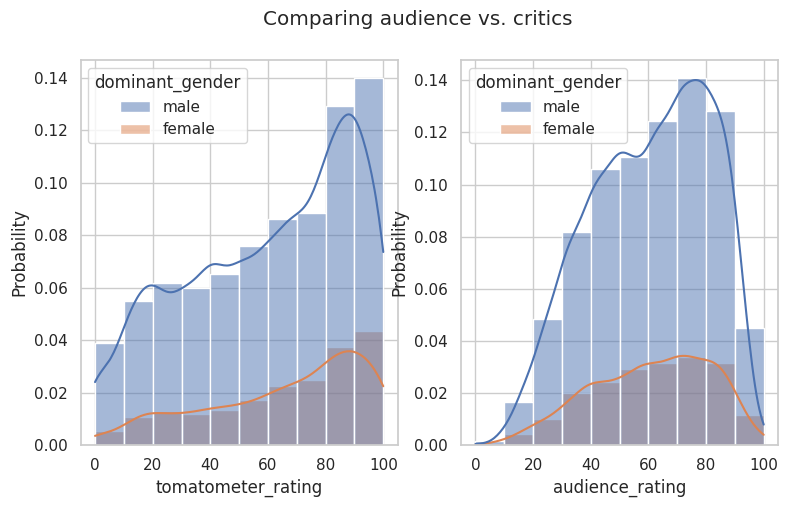

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (9,5))
b = 10
#plt.tight_layout()
sns.histplot(data = movies,
             x = 'tomatometer_rating',
             hue = 'dominant_gender',
             kde=True,
             stat ="probability",
             bins = b,
             ax = ax[0])

sns.histplot(data = movies,
             x = 'audience_rating',
             hue = 'dominant_gender',
             kde = True,
             stat ="probability",
             bins = b,
             ax = ax[1])
fig.suptitle('Comparing audience vs. critics')

As can be seen, the dominating feature of the distributions is that the male gender is way more represented in the data-set. As can be seen below, there is almost twice the amount of males present in the data-set. This could first of indicate that the movie industry is more likely to hire male actors than female. Note that there is also the possibillity that the algorithm used to determine the gender, is somewhat biased towards predicting the male gender. It will however for the rest of the project be assumed that it is not the case. 

In [ ]:
frac = movies.male_count.sum()/movies.female_count.sum()
s = f'Ammount of male actors: {movies.male_count.sum()}\nAmmount of female actors: {movies.female_count.sum()}\nHow many more males: {frac}'
print(s)

Ammount of male actors: 264733
Ammount of female actors: 121697
How many more males: 2.175345324864212


The distributions does not seem to follow a normal distribution so to test if there is significant difference in the two distributions, the The Mann-Whitney test is used, which is a none parametric test for with the null hypothesis that the two samples originate from the same distribution

In [ ]:
fem_df = movies[movies['dominant_gender'] == 'female'].dropna()
male_df = movies[movies['dominant_gender'] == 'male'].dropna()

Test if there is significant difference between the female cast dominated movie ratings from audience and critics

In [ ]:
fem_aud,fem_critic = list(fem_df.audience_rating),list(fem_df.tomatometer_rating)
mannwhitneyu(fem_aud,fem_critic)

MannwhitneyuResult(statistic=759436.0, pvalue=1.8392914842047062e-09)

In [ ]:
mal_aud,mal_critic = list(male_df.audience_rating),list(male_df.tomatometer_rating)
mannwhitneyu(mal_aud,mal_critic)

MannwhitneyuResult(statistic=22797496.5, pvalue=0.5405165169205797)

This indicates that for movies dominated by a female cast, there is a significant difference between the audience rating and the critics ratings. This could indicate a bias in the data. 

Now how about comparing the male and female dominated casts within the audience and tomatometer rating. This means the rating distribtion between female and male audience ratings will be tested, should the test show that the H0 of no difference can be rejected it will showcase a bias. The same will be done for the tomato-meter rating. 

In [ ]:
femal_aud,mal_audience = list(fem_df.audience_rating),list(male_df.audience_rating)
mannwhitneyu(mal_aud,mal_critic)

MannwhitneyuResult(statistic=22797496.5, pvalue=0.5405165169205797)

In [ ]:
femal_aud,mal_audience = list(fem_df.tomatometer_rating),list(male_df.tomatometer_rating)
mannwhitneyu(mal_aud,mal_critic)

MannwhitneyuResult(statistic=22797496.5, pvalue=0.5405165169205797)

From this there is no indication of bias regarding gender in the ratings, since the test fails to reject H0 with significance level $\alpha = 0.05$ in both of the cases above. 

### Does the tomato meter rating and audience rating tell the same thing?


##### Adding the genre to the movie
Another attribute which will be added is the genre of the movie. The movies can contain multiple genres, however for this variable the genre will be assigned as the genre it contains which ranks the highest. This is done since there is a lot of subgenres which can be assigned.

In [ ]:
def find_highest_ranked_genre(movie_genres, ranking_list):
    highest_rank = float('inf')
    highest_ranked_genre = None
    for genre in movie_genres:
        genre = genre.lower()
        if genre in ranking_list:
            rank = ranking_list.index(genre)
            if rank < highest_rank:
                highest_rank = rank
                highest_ranked_genre = genre

    return highest_ranked_genre

In [ ]:
#Also we add the top genre 
movies['top_genre'] = movies['genres'].apply(lambda x: find_highest_ranked_genre(x.split(','),top_genres) if str(x) != 'nan' else 'nan')

### Visualizing the gender count for different genres
Now the gender count variable can be visualized by the top genres for the movie. This could help reveal if certain genres might have some forms of gender bias. Especially action movies and the like, has often been called out for the lack of female characters.

In [ ]:
def display_box_genre(user_genre):
    fig,ax = plt.subplots(1,1)
    
    genre_df = movies[movies['top_genre'] == user_genre]
    colors = ['#aacfcf', '#d291bc']
    male_count,female_count = genre_df['male_count'],genre_df['female_count']
    sns.boxplot(x='gender_count',y='values',
            data=pd.DataFrame({'values':pd.concat([male_count,female_count],axis=0),
                              'gender_count':np.repeat(["Male Count","Female Count"],[len(male_count),len(female_count)])}),
            ax = ax,
            palette=colors,width=0.5,
            showfliers = False
           )
    ax.set_xlabel('Gender')
    
    ax.set_title(f'Gender dist. for {user_genre}')
    plt.show()

genre_dropdown = widgets.Dropdown(
    options=top_genres,
    value=top_genres[0],
    description='Genre To Display:',
    disabled=False,
)

interact(display_box_genre, user_genre=genre_dropdown)

interactive(children=(Dropdown(description='Genre To Display:', options=('drama', 'comedy', 'action & adventur…

<function __main__.display_box_genre(user_genre)>

When clicking through the above genres, it can quite clearly be seen that the female gender is underrepresented in all genres. This does make sence since there is twice as many males in the data-set than females. From the above it can however be seen that there are some genres such as action and adventure in which the two boxplots are further appart than they for fx. romance. Do note that these metrics are a bit skewed by that fact, that the genre has been assigned by ranking, so as the least common genres are selected the counts also decrease. 

# Constructing the graph
Here we will construct the graph, with each node being a movie connected by the actors. The movies will be indexed by the unique rotten tomatoes link, since some movies contains remakes, of old movies and thus they still have the same title.

The weighted edgelist is created such, that the weights of the edges are equal to the size of the set of the actors shared by two movies. 

In [ ]:
def get_weighted_edge_list(movies_df):
    '''
    movies: A pandas dataframe containing the movie data-set from rotten tomatoes
    return: returns a weighted edgelist to which can be read by networkx, each edge is
    represented as: (Movie1,Movie2,weight) where the weight indicates how many actors appear
    in both movies. 
    '''
    # convert the list of actors for each movie into a set
    movies_df['actors_set'] = movies_df['actors'].apply(set)
    
    # create an empty DataFrame to store the edge list
    edge_list = []#pd.DataFrame(columns=['movie1', 'movie2', 'weight'])
    actors = {}
    # compare each pair of movies in the DataFrame
    for i in tqdm(range(len(movies_df))):
        for j in range(i + 1, len(movies_df)):
            # find the actors that are shared between the two movies
            shared_actors = movies_df.loc[i, 'actors_set'].intersection(movies_df.loc[j, 'actors_set'])
            if shared_actors:
                # create an edge between the two movies and set the weight to the number of shared actors
                #edge_list.append()
                edge_list.append((
                    movies_df.loc[i, 'rotten_tomatoes_link'],
                    movies_df.loc[j, 'rotten_tomatoes_link'],
                    len(shared_actors)
                ))
                actors[(movies_df.loc[i, 'rotten_tomatoes_link'],
                        movies_df.loc[j, 'rotten_tomatoes_link'])] = shared_actors
                
    return edge_list,actors

#### Call the weighted edgelist
The function can be run, but do be aware that it does take quite a while to run. Instead the final graph can be loaded, from one of the later cells in the notebook. 

In [ ]:
weighted_edge_list,actors = get_weighted_edge_list(movies)
G = nx.Graph()
G.add_weighted_edges_from(weighted_edge_list)

#### Add the actors set as attributes to each edge
As an edge attribute the set of shared actos are addded. This can prove usefull if the graph is to be inverted to the bigraph. 

In [ ]:
for mov1,mov2 in G.edges:
    try:
        G[mov1][mov2]['Actors'] = list(actors[(mov1,mov2)])
    except:
        G[mov1][mov2]['Actors'] = list(actors[(mov2,mov1)])

In [ ]:
movies = movies.set_index('rotten_tomatoes_link')

In [ ]:
# loop through each node in the graph
remove = []
for node in G.nodes():
    # get the corresponding data from the dataframe
    data = movies.loc[node, 'original_release_date']
    if str(type(data)) == "<class 'pandas.core.series.Series'>": 
        data = data[0]
    # check if the data is above the year 2005
    if data.year > 1980:
        # if it is, keep the node in the graph
        continue
    else:
        # if it is not, remove the node from the graph
        remove.append(node)

G.remove_nodes_from(remove)

## Add the gender of the actors to as node attributes
Once again the gender guesser library will be used for the task.

In [ ]:
for idx,edge in enumerate(G.edges()):
    
    actors = G[edge[0]][edge[1]]['Actors']
    genders = []
    for actor in actors:
        if actor == '' or actor == ' ':
            continue
        actor = actor.split(' ')
        if actor[0] == ' ' or actor[0] == '':
            actor_first_name = actor[1] 
        else: 
            actor_first_name = actor[0]
        gender = d.get_gender(actor_first_name)
        genders.append(gender)
    
    G[edge[0]][edge[1]]['actor_genders'] = genders

### Set a node atribute for director gender and most common actor gender

In [ ]:
def is_pd_series(x):
  """ 
  This is a helper function for determining if x is a pd.series.
  It is helpfull when iterating, since the type returned is not always the same depending on how many instances match the query
  """
  if str(type(x)) == "<class 'pandas.core.series.Series'>":
      return True
  else:
      return False

#### Creating a dictionary containing the attributes 
Now a dictionary of dictionaries will be created containing the attributes, that is to be set on the nodes. 

The following attributes will be added to the nodes: 
- Movie title 
- Tomato meter rating
- Audience rating 
- Genders 
- Genres
-  Production companies
- Content rating


In [ ]:
att = {}
Nan_directors = []
most_freq = lambda List: max(set(List), key = List.count)
for node in G.nodes():
    
    #Extract the relevant collumns
    title = movies.loc[node]['movie_title']
    tomato_rating = movies.loc[node]['tomatometer_rating']
    audience_rating = movies.loc[node]['audience_rating']
    genders = movies.loc[node]['actor_genders']
    genres =  movies.loc[node]['genres']
    production_company = movies.loc[node]['production_company']
    content_rating = movies.loc[node]['content_rating']
    directors = [movies.loc[node]['directors']]
    original_release_date = movies.loc[node]['original_release_date']
    
    if str(directors[0]) == 'nan':
        directors = ['nan']
    #elif 
    
    #Get the most common genders
    director_genders = [d.get_gender(director.split(' ')[0]) for director in directors]
    most_freq_director_gender = most_freq(director_genders)
    
    #Change the most frequent to male or female
    if most_freq_director_gender == 'mostly_male':
        most_freq_director_gender = 'male'
    elif most_freq_director_gender == 'mostly_female':
        most_freq_director_gender = 'female'
    elif str(type(most_freq_director_gender)) != "<class 'str'>":
        print(str(type(most_freq_director_gender)))
    
    most_freq_actor_gender = most_freq(genders)
    
    att[node] = {'title': title,
                 'tomato_rating':tomato_rating if str(tomato_rating) != 'nan' else 0,
                 'audience_rating':audience_rating if str(audience_rating) != 'nan' else 0,
                 'genders':genders,
                 'production_company': production_company,
                 'most_freq_actor_gender': most_freq_actor_gender,
                 'most_freq_director_gender': most_freq_director_gender,
                 'genre':genres,
                 'content_rating': content_rating,
                 'original_release_date': original_release_date.strftime('%Y-%m-%d %H:%M:%S')}

In [ ]:
nx.set_node_attributes(G,att)

##### Storing the graph 
This will save the created graph

In [ ]:
data = json_graph.node_link_data(G)
# save the data to a JSON file
with open('graph_tomato_link.json', 'w') as f:
    json.dump(data, f)

Loading the graph with all the attributes. 

In [ ]:
with open('graph_with_att.json', 'r') as f:
    data = json.load(f)
G = json_graph.node_link_graph(data)

In [ ]:
list(G.edges)[:2]

[('m/0814255', 'm/10004352-going_the_distance'),
 ('m/0814255', 'm/10008849-married_life')]

In [ ]:
G['m/0814255']['m/10004352-going_the_distance']

{'weight': 1,
 'Actors': [' Christie Laing'],
 'actor_genders': ['mostly_female']}

In [ ]:
# get the degree of each node
degrees = [G.degree(node) for node in G.nodes()]
mean,median,mode = np.mean(degrees),np.median(degrees),stats.mode(degrees).mode[0]
s = f'Number of Nodes: {len(G)}\nNumber of edges: {len(G.edges())}\nMean degree: {mean}\nMedian degree: {median}\nMode degree: {mode}'
print(s)

Number of Nodes: 13511
Number of edges: 1006428
Mean degree: 148.97905410406335
Median degree: 117.0
Mode degree: 267


<ipython-input-10-c046ddd99817>:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mean,median,mode = np.mean(degrees),np.median(degrees),stats.mode(degrees).mode[0]


#### Make datetime objects
Since storing date-time objects in json files is not possible, they have to be converted back 

In [ ]:
for node in G.nodes:
    release_date_str = G.nodes[node]['original_release_date']
    release_date = datetime.strptime(release_date_str, '%Y-%m-%d %H:%M:%S')
    G.nodes[node]['original_release_date'] = release_date

### Now we can answer the question: Does directors of the same gender tend to hire the same actors?
In order to do so, the assortivity with respect to the gender of the director is found. 

In [ ]:
# calculate the attribute assortativity
assortativity = attribute_assortativity_coefficient(G, 'most_freq_director_gender')
print(f"Attribute assortativity: {assortativity:.3f}")

Attribute assortativity: 0.033


### Now do the same for the gender of the actors
The calculation of this coeficient will answer if a gender dominates a cast, are they then also often appearing in other gender dominated casts in other movies? 

In [ ]:
# calculate the attribute assortativity
assortativity = attribute_assortativity_coefficient(G, 'most_freq_actor_gender')
print(f"Attribute assortativity: {assortativity:.3f}")

Attribute assortativity: 0.299


In [ ]:
# calculate the attribute assortativity
assortativity = attribute_assortativity_coefficient(G, 'production_company')
print(f"Attribute assortativity: {assortativity:.3f}")

Attribute assortativity: 0.008


#### Assortivity with respect to rating
The data-set consists of two types of ratings, one which is made by the general public and one which is made by actual movie critics. One thing that was hypothesised before conducting the test was that movie critics would be less biased due to their more professional knowledge of movies, where as the general audience generaly speaking tends to be more affected by seeing familiar faces. 

The reason numeric assortivity would tell something about this hypothesis, is that movies with high reviews tend to often connect with other highly reviewed movies, they share the actors between, meaning if assortivity is found between movies with respect to rating, it would point towards bias against certain actors.
*This could lead to an argument about correlation vs. causation, however in this case the naive approach will be assumed*

In [ ]:
nx.numeric_assortativity_coefficient(G,'tomato_rating')

0.09511000686187794

In [ ]:
nx.numeric_assortativity_coefficient(G,'audience_rating')

0.038686129193401725

This means that actually quite opposite of the original hypothesis, the audience tends to be less biased against certain actors, than the movie critics are. While the correlation of the movie critics might not be really high, it is noteworhely higher than the correlation coefficient of the audience rating. 

#### Degree assortivity 

In [ ]:
nx.degree_assortativity_coefficient(G)

0.11406807990466936

In [ ]:
nx.degree_assortativity_coefficient(G,weight = 'weight')

0.1036229729025614

### Evolution over time 
One thing that is often claimed by the movie industry is their progress towards a more gender equal structure. The validity of these claims can be testet by getting the subgraph for each year, and analysing that. 

In [ ]:
def subgraph_by_year(G, year):
    """
    Returns a subgraph of G containing only the nodes with an 'original_release_date'
    attribute in the specified year.
    """
    # Create a dictionary mapping node names to release dates
    release_dates = {n: G.nodes[n]['original_release_date'] for n in G.nodes()}
    
    # Create a list of nodes that have an 'original_release_date' in the specified year
    year_nodes = [n for n in release_dates if release_dates[n].year == year]
    
    # Create a subgraph containing only the nodes in year_nodes
    subgraph = G.subgraph(year_nodes)
    
    return subgraph

### Now the gender assortivity can be calculated for each year from 1990 to 2020
This will give an indicator on how much movies with a dominant gender tends to share actors with other movies of the same dominant gender. This should be able to tell something about how the movie industry has evolved over-time with regards to gender . 

The way to do this is to loop over all the years, and then create a subgraph for each year, and finding the assortivity with respect to the ```'most_freq_actor_gender'```attribute in the graph. At the same time the degree assortivity is logged as well, which will showcase how the movies tend to connect based on their degree.

In [ ]:
# Define the range of years to compute degree assortativity for
years = range(1990, 2021)

# Create an empty list to store the degree assortativity values for each year
assortativity_values = []
assortativity_values_gender = []

# Compute the degree assortativity for each year and store the results in assortativity_values
for year in years:
    subgraph = subgraph_by_year(G, year)
    assortativity = nx.degree_assortativity_coefficient(subgraph)
    assortativity_values.append(assortativity)
    assortativity_gender = attribute_assortativity_coefficient(subgraph, 'most_freq_actor_gender')

    assortativity_values_gender.append(assortativity_gender)

# Create a pandas dataframe with the year and assortativity values
df = pd.DataFrame({'Year': years, 'Assortativity': assortativity_values})
df_gender = pd.DataFrame({'Year': years, 'Assortativity_gender': assortativity_values_gender})

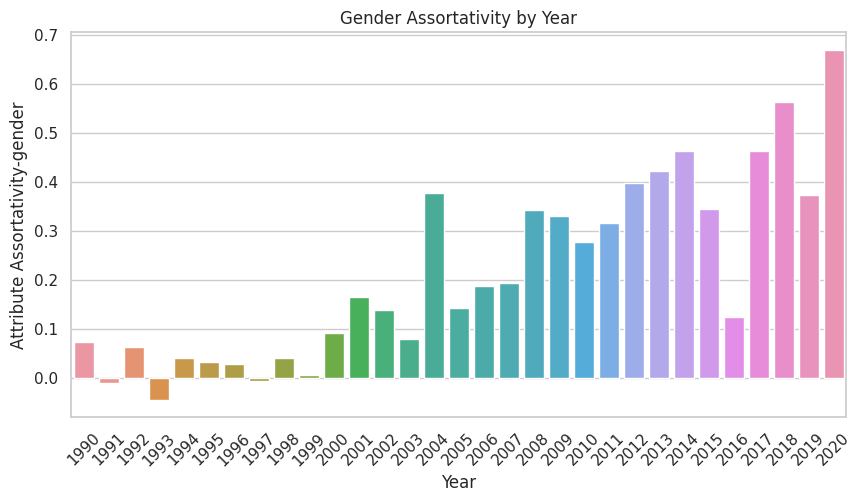

In [ ]:
plt.subplots(1,1,figsize = [10,5])
sns.barplot(data = df_gender, x ='Year', y = 'Assortativity_gender')
plt.xlabel('Year')
plt.ylabel('Attribute Assortativity-gender')
plt.title('Gender Assortativity by Year')
plt.xticks(rotation=45)
plt.show()

What can be seen above as fairly interesting result, since it showcases the fact that the assortativity with respect to gender has increased quite a lot over the years. In short this points towards the fact that movies are actually beginning to share more actors of the same gender with one another. 

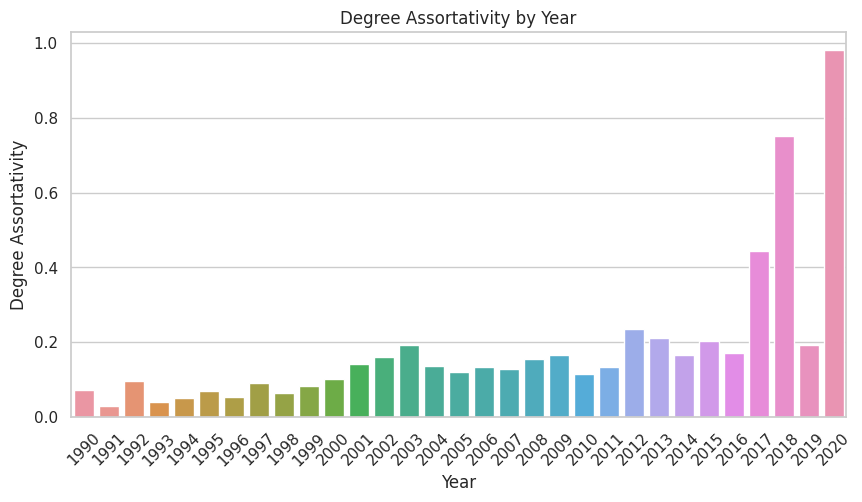

In [ ]:
# Create a barplot of the degree assortativity values by year using seaborn's barplot() function
plt.subplots(1,1,figsize = [10,5])
sns.set(style="whitegrid")
sns.barplot(x='Year', y='Assortativity', data=df)
plt.xlabel('Year')
plt.ylabel('Degree Assortativity')
plt.title('Degree Assortativity by Year')
plt.xticks(rotation=45)
plt.show()

Here it can be seen that the degree assortivity has increased a lot over time, but especially after 2012, the movies tend to be very assortative. This indicates, that it is probaly the same actors appearing the highly connected movies, which could indicate that is quite hard to break into the movie industry because they tend to just share the same actors. 

The degree distribution of the graph can eb vizualised as a histogram: 

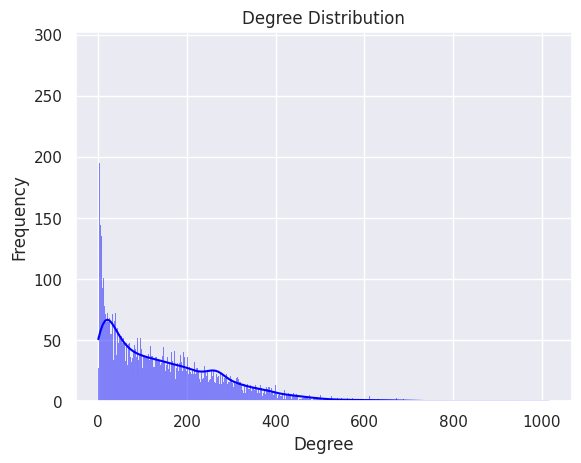

In [ ]:
sns.set_theme()
# plot the degree distribution as a histogram
sns.histplot(degrees, bins=range(max(degrees)+2), color = 'blue',kde = True)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

### Is it well fitted by the power-law?
Now it can be plotted in the log-log scale, this should help reveal if the node degree distribution of the graph actually is modelled well by a power-law distribution. 

Text(0.5, 1.0, 'Histogram in Log-Log Scale')

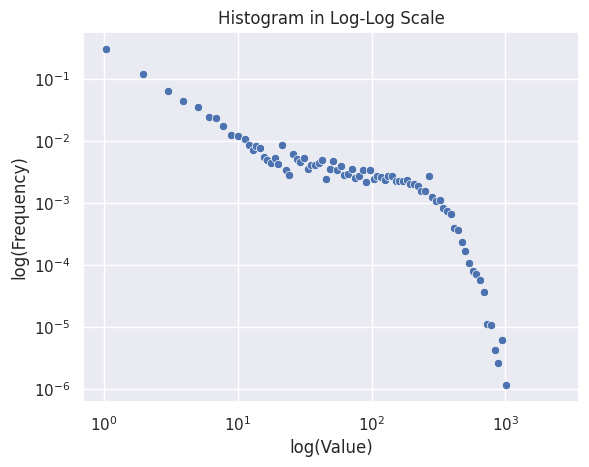

In [ ]:
#Create the histogram
bins = np.logspace(0,np.log10(2500),125)
hist, bins = np.histogram(degrees, bins=bins,density = True)

# Calculate the bin centers,as done in the lectures
bin_centers = (bins[:-1] + bins[1:]) / 2
fig,ax = plt.subplots(1,1)
sns.scatterplot(x=bin_centers, y=hist, marker='o',ax = ax)

#labels and title
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.title('Histogram in Log-Log Scale')

### Connectivity of genres
A thing which was discussed prior to the project, was the fact that it sometimes seemed like actors were in the same genres of movies. Based on this the attribute mixing matrix can constructed for the variable top genre. The validity of this variable is debateable since the way it is assigned makes a lot of movies fall into one category (action & adventure), and only very few into the others. For the same reason only the top ten is plotted. 

In [ ]:
movies = movies.set_index('rotten_tomatoes_link')

In [ ]:
#movies['top_genre']
for node in G.nodes():
  top_genre = movies.loc[node]['top_genre']
  G.nodes[node]['top_genre'] = top_genre

<Axes: >

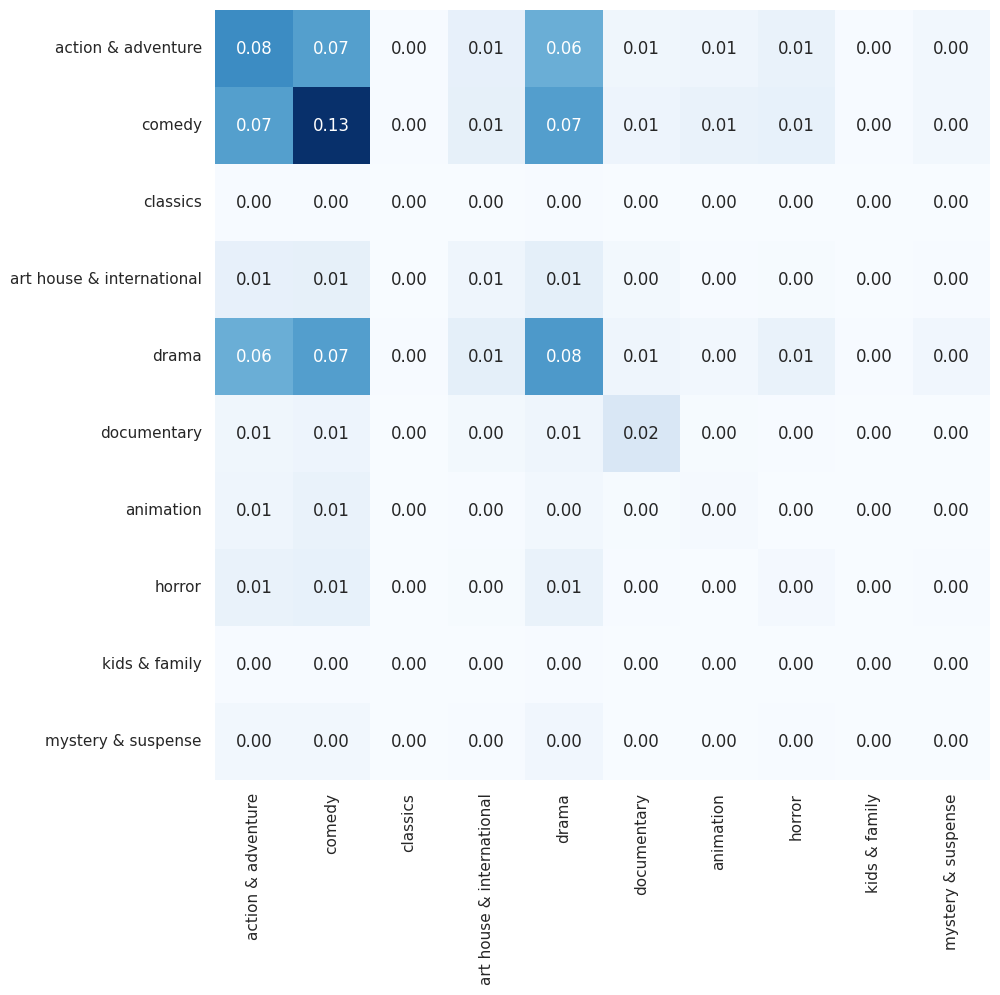

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
mapping = {content:idx for idx,content in enumerate(movies.top_genre.unique())}
matrix = nx.attribute_mixing_matrix(G,'top_genre',mapping=mapping)
sns.heatmap(matrix[:10,:10],
            annot = True,
            xticklabels = list(mapping.keys())[:10],
            yticklabels = list(mapping.keys())[:10],
            cbar =False,
            cmap='Blues',
            fmt='.2f')

What can be seen is that only comedy seems to have a real sense of hiring the same actors, and connecting a lot to eachother, while the reast of the genre shows almost no connectivity at all, not even within their own genre. 

### How does movies connect by the content rating? 
A smaller yet fairly interesting result which was found in working with teh graph, was the fact that some categories of movies based on the content rating showed a tendency to connect. This result was found by constructing the attribute mixing matrix *(seen below)*, which showcased that the movied rated r rated movies showed tendency to connect more than any other movie. Also the r rated movies and pg-13 movies tended to share a lot of actors with one another. The rest of the network has quite a low coeficient pointing towards the fact that there is no tendency to connect within the content rating. 

<Axes: >

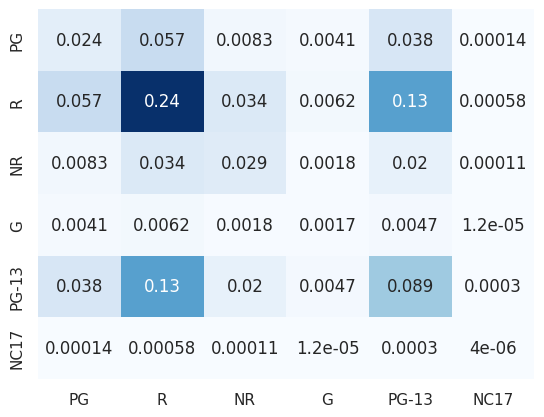

In [ ]:
mapping = {content:idx for idx,content in enumerate(movies.content_rating.unique())}
matrix = nx.attribute_mixing_matrix(G,'content_rating',mapping=mapping)
sns.heatmap(matrix,
            annot = True,
            xticklabels = list(mapping.keys()),
            yticklabels = list(mapping.keys()),
            cbar =False,
            cmap='Blues')

### Inverting the problem ie. create the bi-graph 
The entire problem can be thought of in another way, where the actors appear as nodes, and where the edges are movies in which they both appeared. This will differ from the graph before, since it will tell how actors connect, to eachoter and could shed more ligth on how actors tend to collaborate with one another. 

Furthermore it allows us to see if there is any tendencies with regards to connection acroos genders which is the primary focus of the research.

The way the graph is inverted is by iterating thorugh each movie, and then each of the actors in the movie, and let them connect to one another, because their appear in the same movie. 

In [ ]:
movies = movies.reset_index()

In [ ]:
# Create an empty graph
G_bi = nx.Graph()

# Create a dictionary to store the count of movies for each pair of actors
actor_pairs = {}

# Iterate over the rows of the DataFrame
for _, row in movies.iterrows():
    movie = row['rotten_tomatoes_link']
    actors = row['actors']
    
    # Update the count of movies for each pair of actors
    if str(actors) == 'nan':
        continue
    for i in range(len(actors)):
        for j in range(i + 1, len(actors)):
            actor1 = actors[i]
            actor2 = actors[j]
            
            # Increase the count of movies for the actor pair
            if (actor1, actor2) in actor_pairs:
                actor_pairs[(actor1, actor2)] += 1
            else:
                actor_pairs[(actor1, actor2)] = 1

# Add weighted edges between the actors based on the count of movies
for (actor1, actor2), count in actor_pairs.items():
    G_bi.add_edge(actor1, actor2, weight=count)

In [ ]:
len(G_bi),len(G_bi.edges())

(209697, 8573136)

In [ ]:
# Add the gender as an attribute to the graph
remove = []
for node in G_bi.nodes():
    n = node.split(' ')
    if (n[0] == '' or n[0] == ' ') and len(n) > 1:
        name = n[1]
    elif n[0] != '' or n[0] != ' ':
        name = n[0]
    elif len(n) == 1:
        remove.append(node)
        continue
    gender = d.get_gender(name)
    
    #Change the most frequent to male or female
    if gender == 'mostly_male':
        gender = 'male'
    elif gender == 'mostly_female':
        gender = 'female'
    elif gender == 'unknown' or gender == 'andy':
        remove.append(node)
        continue
    
    if gender == 'andy':
        print(node)
    
    G_bi.nodes[node]['gender'] = gender
    
G_bi.remove_nodes_from(remove)

From the above code, som of the nodes are removed if the gender can't be determined, this is done since nan or unknown values would make it very hard to state anything about the graph with respect to genders, since if there is a lot of unknowns the assortativity as an example could be affected since there might be a lot of unkowns. 

The graph now has the following properties attached to it: 

In [ ]:
# get the degree of each node
degrees = [G_bi.degree(node) for node in G_bi.nodes()]
mean,median,mode = np.mean(degrees),np.median(degrees),stats.mode(degrees).mode[0]
s = f'Number of Nodes: {len(G_bi)}\nNumber of edges: {len(G_bi.edges())}\nMean degree: {mean}\nMedian degree: {median}\nMode degree: {mode}'
print(s)

Number of Nodes: 182611
Number of edges: 6896652
Mean degree: 75.5338068352947
Median degree: 44.0
Mode degree: 27


<ipython-input-57-d14801a74949>:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mean,median,mode = np.mean(degrees),np.median(degrees),stats.mode(degrees).mode[0]


#### How does actors connect across genders?
Prior to the research, it was speculated that actors would tend to be more connected with the same gender, due to most movies following classic gender stereotypic roles. By this things such as superhero movies often only employing male actors should mean that fx male actors would tend to connect more with other male actors. 

In [ ]:
# calculate the attribute assortativity
assortativity = attribute_assortativity_coefficient(G_bi, 'gender')
print(f"Attribute assortativity: {assortativity:.3f}")

Attribute assortativity: 0.052


From this it can be seen that the original hypothesis did not seem to be true, indicating that actors do not tend to connect based on gender.

Another relevant question is the genreal connectivity of the actors. 

In [ ]:
nx.degree_assortativity_coefficient(G_bi)

0.08273384835398773

This indicates that actors are not nescesarrilily connected with other actors of the same degree.

But how do the degree distribution look for the actors? 

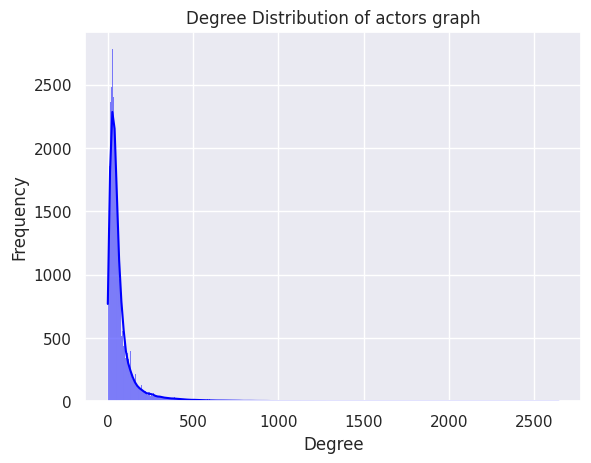

In [ ]:
sns.set_theme()
# plot the degree distribution as a histogram
sns.histplot(degrees, bins=range(max(degrees)+2), color = 'blue',kde = True)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of actors graph')
plt.show()

This may indicate a power law distribution in the actors graph, however by plotting the histogram in log-log scale, it should show a straight line, if it follows the power law distribution.

Plotting the degree distribution in log-log scale:


In [ ]:
np.histogram(degrees, bins=bins,density = True)

Text(0.5, 1.0, 'Histogram in Log-Log Scale')

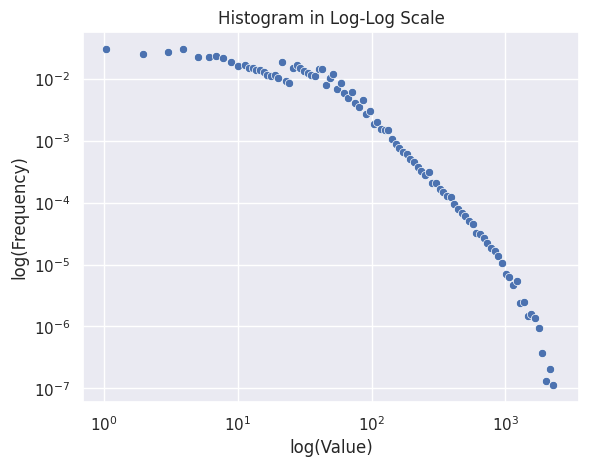

In [ ]:
#Histogram
bins = np.logspace(0,np.log10(2500),125)
hist, bins = np.histogram(degrees, bins=bins,density = True)

# Calculate the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2
fig,ax = plt.subplots(1,1)
sns.scatterplot(x=bin_centers, y=hist, marker='o',ax = ax)

#labels and title
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.title('Histogram in Log-Log Scale')

So from these results it does look like a straight line could fit the histogram reasonably well. 

From the graph a top 10 can be constructed, which gives the top ten most connected actors. Note that the degree centrality is used, since this is a built in function from networkx, it makes is quite a lot faster then iterating the entire graph. Recall that the degree centrality for a node is: $ \frac{\#links}{max\:possible\:links} $

In [ ]:
def get_top_10_actors(graph):
    """
    Returns the top 10 most connected actors based on degree centrality in the graph.
    """
    degree_centrality = nx.degree_centrality(graph)
    sorted_actors = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
    sorted_actors = [(actor,degree_centrality[actor]) for actor in sorted_actors]
    # Return the top 10 most connected actors
    top_10_actors = sorted_actors[:10]
    return top_10_actors

In [ ]:
get_top_10_actors(G_bi)

[(' Samuel L. Jackson', 0.01447346804665681),
 (' Richard Schiff', 0.012781337276162314),
 (' Richard Jenkins', 0.01232134056185313),
 (' Keith David', 0.012162532172389245),
 (' Steve Buscemi', 0.012031104539729479),
 (' John Goodman', 0.011888724604348064),
 (' Morgan Freeman', 0.011773725425770768),
 (' Christopher Walken', 0.011718963912162532),
 (' Stanley Tucci', 0.011450632495482175),
 (' Mike Starr', 0.011313728711461584)]

### Visualize it with a barplot 
The above results are now presented in a visual format, note that the factor which they where divied with in the networkx implementation is multiplied with the centrality coeficient. 

Text(0.5, 1.0, 'Top 10 most connected actors')

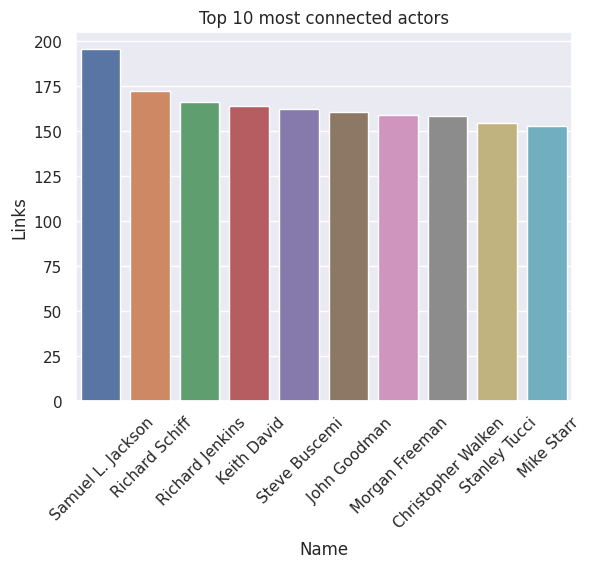

In [ ]:
factor = len(G)-1
x = get_top_10_actors(G_bi)
l = {i[0]:float(i[1]*factor) for i in x}
names = list(l.keys())
values = list(l.values())

# Create a barplot using Seaborn
sns.barplot(x=names, y=values)

# Set labels and title
plt.xlabel('Name')
plt.ylabel('Links')
plt.xticks(rotation=45)
plt.title('Top 10 most connected actors')

Here two things are quite obvious first of the normal names such as Samuel L. Jackson appears as well as Morgan Freeman. Eventhough this research does not include any specific age, they are mostly older actors, which makes quite a lot of sence, since they would have appeared in more movies, having more co-stars than the younger actors. These actors are the hubs of the network, since they are the few very highly connected nodes. 

The second thing is that they are all male actors. This however does also make somewhat sence, when thinking of the fact that there are almost twice as many male actors than female in the data-set. However it could also indicate the fact that male actors have an easier time being castet and thus conencting with more actors than female. It could be caused by the fact that males tend to be castet on to bigger sets with a larger cast, which would also make them better conected. 

Now we can get the top 10 female actors aswell, roughly the same as before however only get the female actors. 

In [ ]:
def get_top_10_female_actors(graph):
    """
    Returns the top 10 most connected actors of the given gender based on degree centrality in the graph.
    """
    degree_centrality = nx.degree_centrality(graph)
    filtered_actors = [actor for actor in degree_centrality if graph.nodes[actor]['gender'] == 'female']
    
    # Sort the actors based on degree centrality in descending order
    sorted_actors = sorted(filtered_actors, key=degree_centrality.get, reverse=True)
    sorted_actors = [(actor,degree_centrality[actor]) for actor in sorted_actors]
    # Return the top 10 most connected actors
    top_10_actors = sorted_actors[:10]
    return top_10_actors

In [ ]:
get_top_10_female_actors(G_bi)

[(' Susan Sarandon', 0.009813263238595915),
 (' Laurence Fishburne', 0.009763977876348503),
 (' Tracey Walter', 0.009599693335523794),
 (' Joan Cusack', 0.009249219648431083),
 (' Lin Shaye', 0.009101363561688846),
 (' Marisa Tomei', 0.008969935929029078),
 (' Colleen Camp', 0.008854936750451783),
 (' Kathy Bates', 0.00866874760418378),
 (' Allison Janney', 0.008312797765730245),
 (' Elizabeth Banks', 0.008279940857565303)]

Text(0.5, 1.0, 'Top 10 most connected female actors')

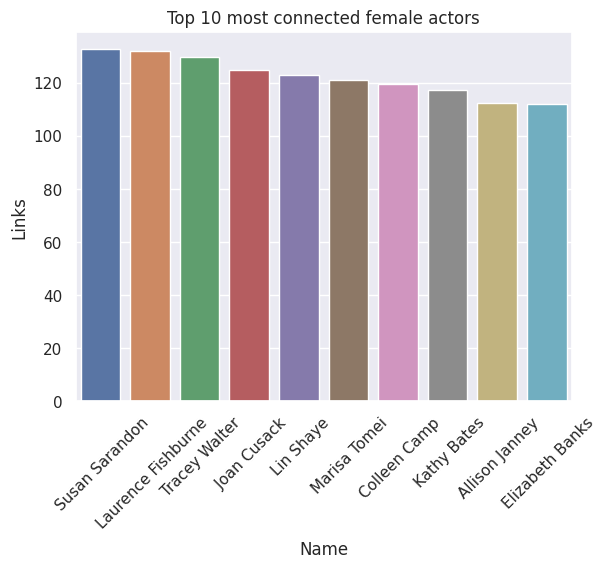

In [ ]:
#Visualization same as before
factor = len(G)-1
x = get_top_10_female_actors(G_bi)
l = {i[0]:float(i[1]*factor) for i in x}
names_fem = list(l.keys())
values_fem = list(l.values())

# Create a barplot using Seaborn
sns.barplot(x=names_fem, y=values_fem)

# Set labels and title
plt.xlabel('Name')
plt.ylabel('Links')
plt.xticks(rotation=45)
plt.title('Top 10 most connected female actors')

Here the on of the noteworthy things would be that, the degree centrality is way lower for the top 10 women than the top 10 overall (which is ofcourse dominated by male actors). It was ofcourse expected that they would be lower based on the prior results, however it is noteworthy just how much lower they are. 

Visualise next to each other for better comparison. 

Text(0.5, 1.0, 'Top 10 most connected female actors')

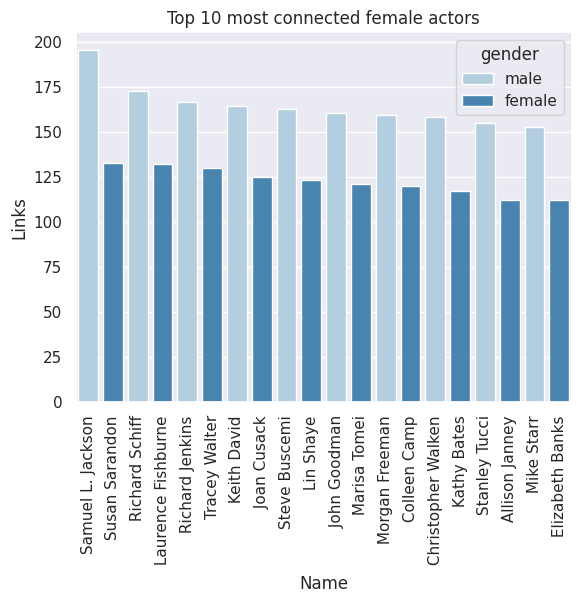

In [ ]:
val_c = np.array([[v,vf] for v,vf in zip(values,values_fem)]).ravel()
name_c = np.array([[v,vf] for v,vf in zip(names,names_fem)]).ravel()
hue = ['male' if i%2 == 0 else 'female' for i in range(len(val_c))]
data = {'value':val_c,'name':name_c,'gender':hue}
data = pd.DataFrame(data)
# Create a barplot using Seaborn
sns.barplot(data = data,
            x='name',
            y='value',
            hue = 'gender',
            dodge = False,
            palette = 'Blues')

# Set labels and title
plt.xlabel('Name')
plt.ylabel('Links')
plt.xticks(rotation=90)
plt.title('Top 10 most connected female actors')

#Community visualization and comparison

This part will assess the various communities present in the network. The analysis uses the graph constructed in the previous section. This is the filtered version of the original dataset, where the movies before 2005 and the attached links were removed.
Re-loading the graph from json then loading it into a Networkx graph class:

In [ ]:
with open("graph.json") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data)

This work approaches and constrasts 3 types of communities present in the network. The first two are determined by the movie attributes, such as content rating (G, PG, R, etc...), and genre.

The third grouping is calculated using the Louvain algorithm to find communities based on the connections (actors) between the nodes (movies). 

In [ ]:
louvainPartition_tmp = community_louvain.best_partition(G, resolution=5)

The code above uses a built in function from neworkx to do the louvain partitioning. The 'resolution' parameter determines the sizes of the found commuities, a higher resolution means the algorithm creates more groups as the criteria, how densely connected should a community be, increases.

The chosen parameter (5) is solely experimental, as this created a fair amount of separate groups (around 280). The defaut value 1 created 2 really large groups and it made the further comparison harder and less relevant.

In [ ]:
#should be around 280
all_comms = max(louvainPartition_tmp.values())
print("Communities found: " + str(all_comms))

Adding the partition number as an attribute to the nodes:

In [ ]:
for item in louvainPartition_tmp:
    G.nodes[item].update({"louvain": louvainPartition_tmp[item]})

In [ ]:
#create copy to work with
mydict = louvainPartition_tmp

It turned out there were still communities too small, so the ones counting less than 30 movies were removed (based on statistics 30 is the smallest sample size that could be considered in computations, and also an average actor stars in around 30 movies)

In [ ]:
#func to count items in community
def countCommunityItems(mydict):
    count = {}
    for key, value in mydict.items():
        if value not in count:
            count[value] = 1
        else:
            count[value] += 1
    return count

In [ ]:
#sort out communities with more than 30 nodes to new dict
count = countCommunityItems(mydict)
mydict2 = {}
for key, value in mydict.items():
    if count[value] >= 30:
        mydict2[key] = value

In [ ]:
#reuse variables, this basically drops the too small communities
mydict = mydict2
count = countCommunityItems(mydict)

Since the output format of the built in function is hard to work with, now some adjustments to make the groups more managable.

In [ ]:
#copy count keys to list
count_list = []
for key, value in count.items():
    count_list.append(key)

In [ ]:
#add all movies to communities
newdict = {}
for i in count_list:
    movielist = []
    for key, value in mydict.items():
        if value == i:
            movielist.append(key)
    newdict[i] = movielist

To perform the visualization and create some comparable data, each node was labeled with its rating and genre.

In [ ]:
#create dict, key is rating and value is list of movies with that rating
#we will use the filtered dict, to work with the same data
rating_dict = {}
rating_list = []
for item in G.nodes:
    rating_dict[item] = G.nodes[item]['content_rating']
    if G.nodes[item]['content_rating'] not in rating_list:
        rating_list.append(G.nodes[item]['content_rating'])

In [ ]:
#add all movies to communities
movies_dict_byrating = {}
for i in rating_list:
    movielist = []
    for key, value in rating_dict.items():
        if value == i:
            movielist.append(key)
    movies_dict_byrating[i] = movielist

In [ ]:
#export movies_dict_byrating to csv
for key, value in movies_dict_byrating.items():
    with open(key + '.csv', 'w') as f:
        for item in value:
            f.write("%s\n" % item)

In [ ]:
#create dict, key is genre and value is list of movies with that genre
#we will use the filtered dict, to work with the same data
genre_dict = {}
genre_list = []
for item in G.nodes:
    genre_dict[item] = G.nodes[item]['genre']
    if G.nodes[item]['genre'] not in genre_list:
        genre_list.append(G.nodes[item]['genre'])

In [ ]:
#add all movies to communities
movies_dict_bygenre = {}
for i in genre_list:
    movielist = []
    for key, value in genre_dict.items():
        if value == i:
            movielist.append(key)
    movies_dict_bygenre[i] = movielist

It appeared that there were too many too specific cagetories, consisting of a couple of movies, so in order to simplify this, categories with less than 3 movies were merged into a common category called 'mixed'. This resulted in roughly 280 separate groups, which was convenient as it matched the number of louvain communities.

In [ ]:
#store genres with less than 3 movies in a list
weirdgenres = []
for key, value in movies_dict_bygenre.items():
    if len(value) < 3:
        weirdgenres.append(key)

In [ ]:
#unify too unique genres
keys_to_delete = []
weirdlist = []
for key, value in movies_dict_bygenre.items():
    if key in weirdgenres:
        for item in value:
            weirdlist.append(item)
        keys_to_delete.append(key)

for i in keys_to_delete:
    del movies_dict_bygenre[i]

movies_dict_bygenre['Mixed'] = weirdlist

To be able to export only the necessary data, some adjustments were needed.

In [ ]:
#reverse dictionaries to make iteration easier
reversedict_louvain = {}
reversedict_genre = {}
reversedict_rating = {}
for key, value in newdict.items():
    for item in value:
        reversedict_louvain[item] = key
for key, value in movies_dict_bygenre.items():
    for item in value:
        reversedict_genre[item] = key
for key, value in movies_dict_byrating.items():
    for item in value:
        reversedict_rating[item] = key

In [ ]:
#iterate through G and copy common nodes to new graph add edges
G2 = nx.Graph()
for node in G.nodes():
    if node in reversedict_louvain:
        try:
            G2.add_node(node, louvain=reversedict_louvain[node], genre=reversedict_genre[node], rating=reversedict_rating[node])
            for neighbor in G.neighbors(node):
                if neighbor in reversedict_louvain:
                    G2.add_node(neighbor, louvain=reversedict_louvain[neighbor], genre=reversedict_genre[neighbor], rating=reversedict_rating[neighbor])
                    G2.add_edge(node, neighbor)
        except:
            pass

In [ ]:
#export graph with attributes
nx.write_gexf(G2, "graph.gexf")

Data visualization was performed using a tool specified to handle large communities, called Gephi. On the picture below represents the network after the removal of the small communities. It consists of 11900 nodes and 784634 edges.

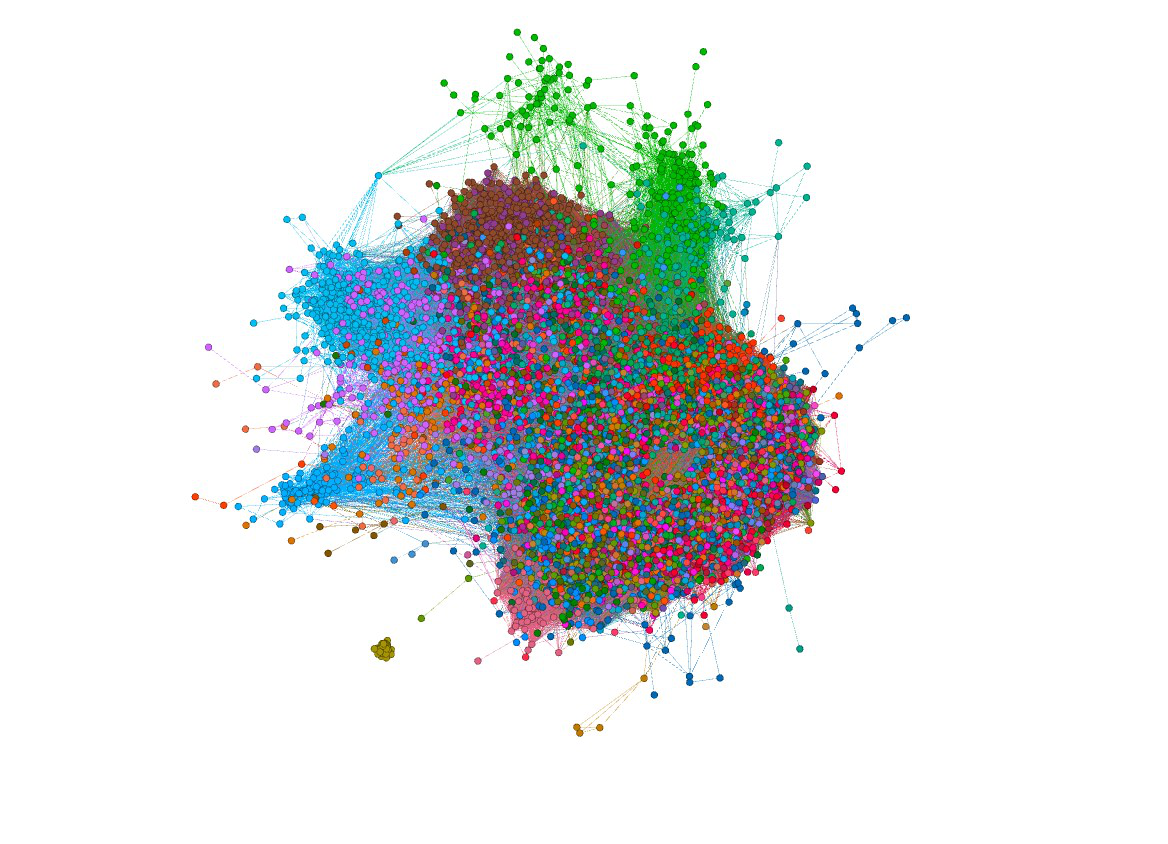

In [ ]:
img = Image.open("full.jpg")
img.show()

For a better overview and comparison, just displaying the 10 largest communities. Each color represents a community found by the Louvain algorithm.

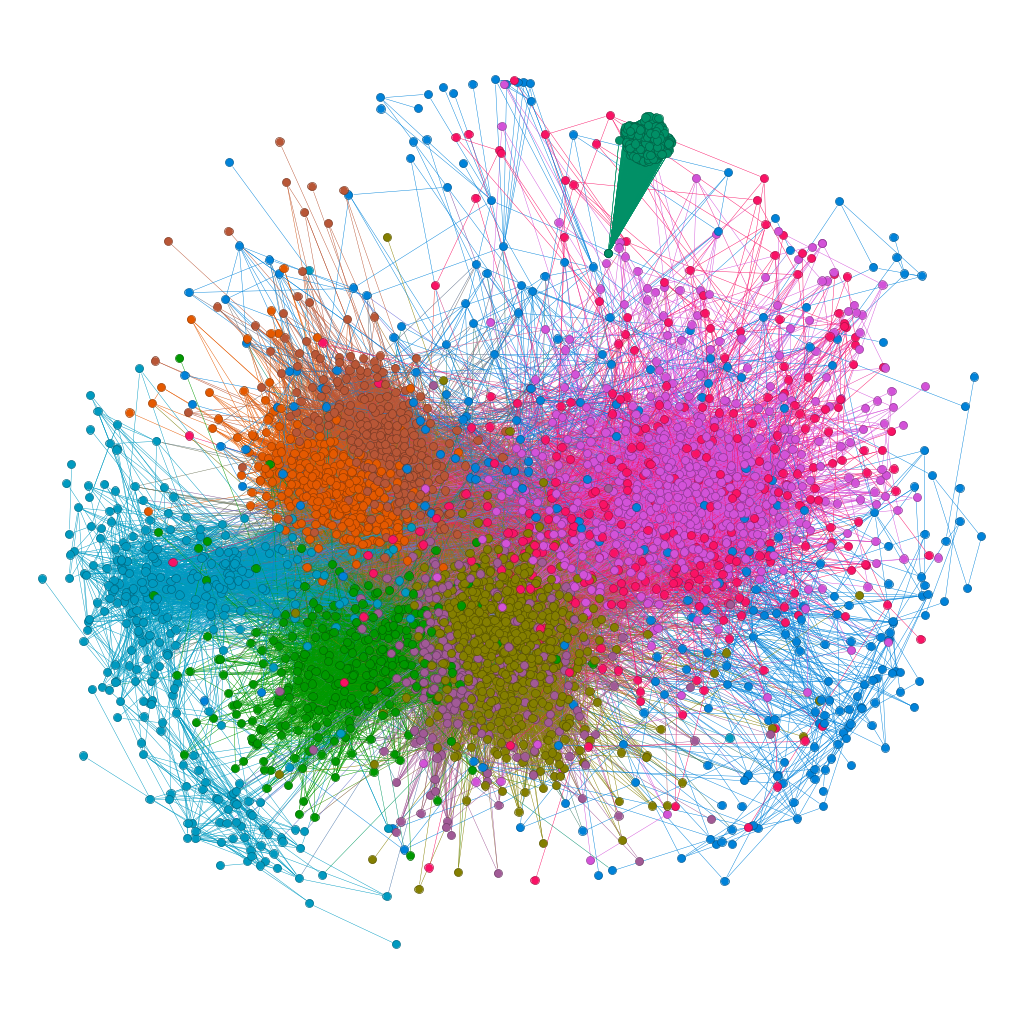

In [ ]:
img = Image.open("luvfull.png")
img.show()

For the comparison each group is shown separately and recolored by genre:

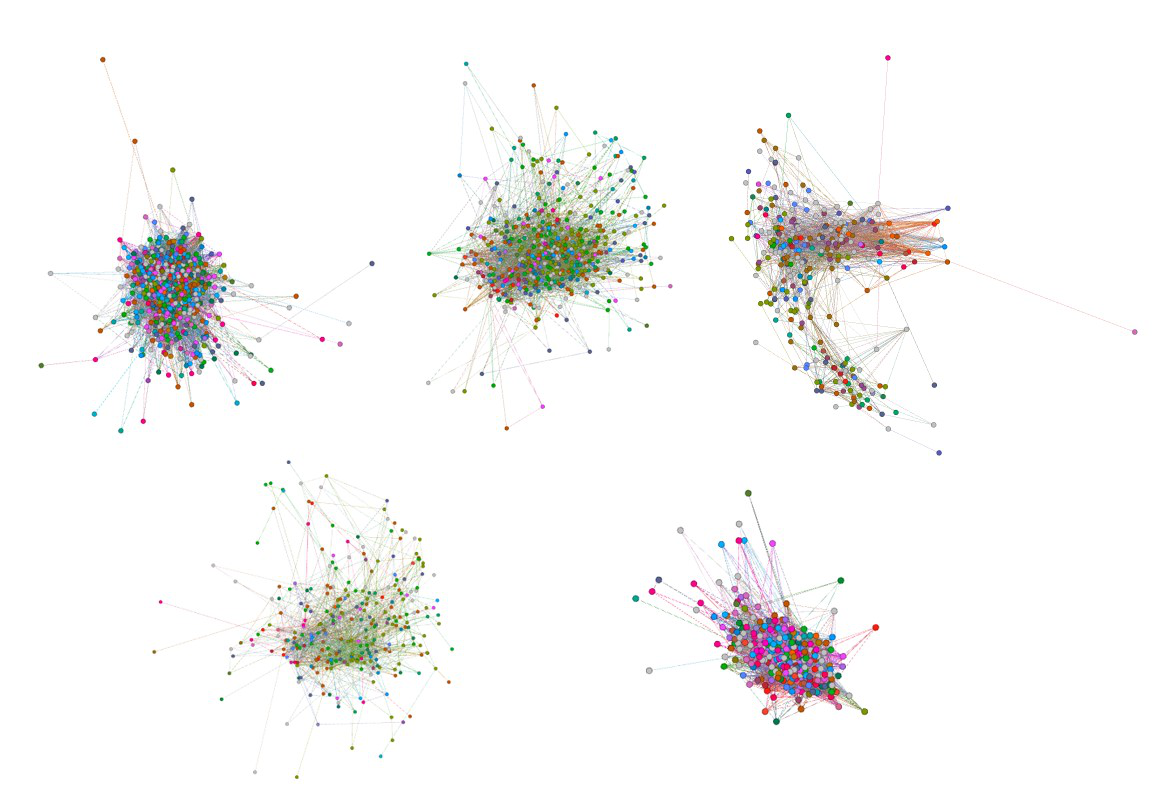

In [ ]:
img = Image.open("first 5.jpg")
img.show()

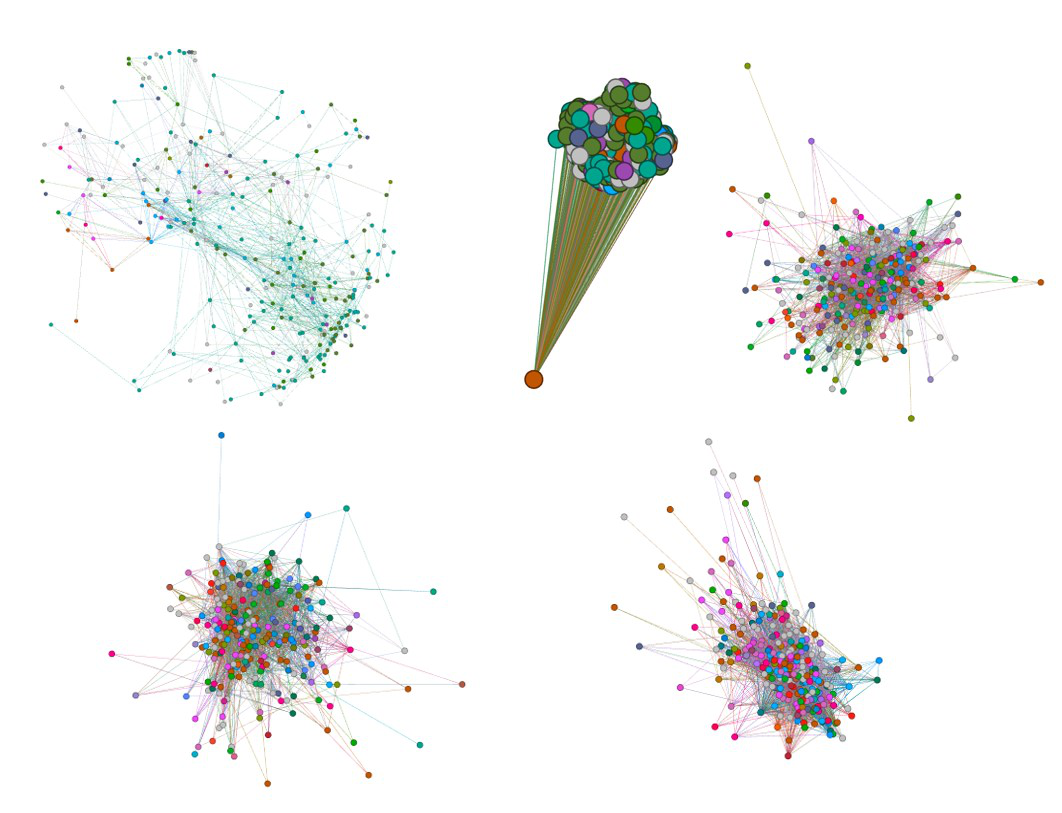

In [ ]:
img = Image.open("bot 5.jpg")
img.show()

Some computations to back up intuitions regarding the visuals:

In [ ]:
#iterate through G2 and count genre occurance for each louvain community
genre_count = {}
for node in G2.nodes():
    if node in reversedict_louvain:
        if reversedict_louvain[node] not in genre_count:
            genre_count[reversedict_louvain[node]] = {}
            genre_count[reversedict_louvain[node]][reversedict_genre[node]] = 1
        else:
            if reversedict_genre[node] not in genre_count[reversedict_louvain[node]]:
                genre_count[reversedict_louvain[node]][reversedict_genre[node]] = 1
            else:
                genre_count[reversedict_louvain[node]][reversedict_genre[node]] += 1
                

In [ ]:
rating_count = {}
for node in G2.nodes():
    if node in reversedict_louvain:
        if reversedict_louvain[node] not in rating_count:
            rating_count[reversedict_louvain[node]] = {}
            rating_count[reversedict_louvain[node]][reversedict_rating[node]] = 1
        else:
            if reversedict_rating[node] not in rating_count[reversedict_louvain[node]]:
                rating_count[reversedict_louvain[node]][reversedict_rating[node]] = 1
            else:
                rating_count[reversedict_louvain[node]][reversedict_rating[node]] += 1

!!Important note, the below cell is hard coded for the selected 10 largest communities, so re-running the cells will produce different results, rendering this cell useless!!

In [ ]:
#calculating the percentage of the most dominant genre for the 10 largest louvain group
no1_mfreqg = max(genre_count[16], key=genre_count[16].get)
no2_mfreqg = max(genre_count[27], key=genre_count[27].get)
no3_mfreqg = max(genre_count[47], key=genre_count[47].get)
no4_mfreqg = max(genre_count[262], key=genre_count[262].get)
no5_mfreqg = max(genre_count[0], key=genre_count[0].get)
no6_mfreqg = max(genre_count[56], key=genre_count[56].get)
no7_mfreqg = max(genre_count[243], key=genre_count[243].get)
no8_mfreqg = max(genre_count[33], key=genre_count[33].get)
no9_mfreqg = max(genre_count[13], key=genre_count[13].get)
no10_mfreqg = max(genre_count[9], key=genre_count[9].get)

print(genre_count[16][no1_mfreqg]/sum(genre_count[16].values()))
print(genre_count[27][no2_mfreqg]/sum(genre_count[27].values()))
print(genre_count[47][no3_mfreqg]/sum(genre_count[47].values()))
print(genre_count[262][no4_mfreqg]/sum(genre_count[262].values()))
print(genre_count[0][no5_mfreqg]/sum(genre_count[0].values()))
print(genre_count[56][no6_mfreqg]/sum(genre_count[56].values()))
print(genre_count[243][no7_mfreqg]/sum(genre_count[243].values()))
print(genre_count[33][no8_mfreqg]/sum(genre_count[33].values()))
print(genre_count[13][no9_mfreqg]/sum(genre_count[13].values()))
print(genre_count[9][no10_mfreqg]/sum(genre_count[9].values()))

The genre distribution of the communities doesn't show strong patterns, when calculating the numbers only 2 communities show somewhat of a dominance of a genre (above 30% of the community).The two dominant genres are Documentary and Documentary, Special interest.
In those cases it must be noted, that they don't have actors starring in them, so they are connected by the faulty 'nan' actor. Although logical, this phenomenon was only spotted by the team after the visualization.

Worth mentioning the genre 'Art House & International, Drama' which scored a 20% presence rate in 2 of the largest groups, which shows a possible tendency of a more closed circle of actors starring in them.

Initially the same analysis was planned regarding the content ratings, but given that almost 50% of the movies rated R and there are only 6 categories, this hadn't produced meaningful results.

In preparation of the text analysis, for each community the corresponding average rating is added (audience rating and critic rating separately). In order to compensate the different community sizes, the ratings are given with a confidence interval, which accounts for the sample size. This offers a good comparison, and luckily most of the time there aren't too muh overlapping among the groups, so the outliers could be determined. In the text analysis part the best and worst rated movie groups will be taken into consideration.

In [ ]:
#comparing different community sizes is not obvious, so compensate for the sample size with error bars
#mean audience rating of each community
audience_ratings_dict = {}
for key, value in newdict.items():
    scores = []
    for i in value:
        scores.append(G.nodes[i]["audience_rating"])
    avg = np.mean(scores)
    std = np.std(scores)
    standard_error = std / np.sqrt(len(value))
    t_value = t.ppf(0.975, len(value) - 1)
    conf_interval = [avg - t_value * standard_error, avg + t_value * standard_error]
    audience_ratings_dict[key] = conf_interval

In [ ]:
#mean tomato rating of each community
tomato_ratings_dict = {}
for key, value in newdict.items():
    scores = []
    for i in value:
        scores.append(G.nodes[i]["tomato_rating"])
    avg = np.mean(scores)
    std = np.std(scores)
    standard_error = std / np.sqrt(len(value))
    t_value = t.ppf(0.975, len(value) - 1)
    conf_interval = [avg - t_value * standard_error, avg + t_value * standard_error]
    tomato_ratings_dict[key] = conf_interval

Visualizing the averages with error bars in an increasing order:

In [ ]:
#sort dicts
audience_ratings_dict = dict(sorted(audience_ratings_dict.items(), key=lambda item: item[1][0]))
tomato_ratings_dict = dict(sorted(tomato_ratings_dict.items(), key=lambda item: item[1][0]))

#plot tomato ratings
plt.figure(figsize=(20, 10))
plt.errorbar(range(len(tomato_ratings_dict)),
[x[0] for x in tomato_ratings_dict.values()],
yerr=[(x[1] - x[0]) / 2 for x in tomato_ratings_dict.values()],
fmt='o')
plt.title("Tomato ratings of communities")
plt.xlabel("Communities) [nth community after sorting]")
plt.ylabel("Tomato rating [%]")
plt.show()

In [ ]:
#plot audience ratings
plt.figure(figsize=(20, 10))
plt.errorbar(range(len(audience_ratings_dict)),
[x[0] for x in audience_ratings_dict.values()],
yerr=[(x[1] - x[0]) / 2 for x in audience_ratings_dict.values()],
fmt='o')
plt.title("Audience ratings of communities")
plt.xlabel("Communities) [nth community after sorting]")
plt.ylabel("Audience rating [%]")
plt.show()

Visualizing the ratings on top of each other. Note that both are sorted separately, so the X-axis doesn't represent the actual communities that have that rating. It's more of just an indication of the range of the audience vs the critics ratings.

In [ ]:
#contrast tomato and audience ratings
plt.figure(figsize=(20, 10))
plt.errorbar(range(len(tomato_ratings_dict)),
[x[0] for x in tomato_ratings_dict.values()],
yerr=[(x[1] - x[0]) / 2 for x in tomato_ratings_dict.values()],
fmt='o', label="Tomato ratings")
plt.errorbar(range(len(audience_ratings_dict)),
[x[0] for x in audience_ratings_dict.values()],
yerr=[(x[1] - x[0]) / 2 for x in audience_ratings_dict.values()],
fmt='o', label="Audience ratings")
plt.title("Tomato and audience ratings of communities")
plt.xlabel("Communities) [nth community after sorting]")
plt.ylabel("Rating [%]")
plt.legend()
plt.show()


Selecting and exporting the two extremes to do the text analysis on:

In [ ]:
#find highest rated community
highest_tomato = max(tomato_ratings_dict, key=tomato_ratings_dict.get)
highest_audience = max(audience_ratings_dict, key=audience_ratings_dict.get)
print("Highest rated community by tomato rating: " + str(highest_tomato))
print("Highest rated community by audience rating: " + str(highest_audience))
#find lowest rated community
lowest_tomato = min(tomato_ratings_dict, key=tomato_ratings_dict.get)
lowest_audience = min(audience_ratings_dict, key=audience_ratings_dict.get)
print("Lowest rated community by tomato rating: " + str(lowest_tomato))
print("Lowest rated community by audience rating: " + str(lowest_audience))

In [ ]:
#double check sample size
count[highest_tomato], count[highest_audience], count[lowest_tomato], count[lowest_audience]

After checking the sample size for the extremes, the team was a bit concerned about maybe a faulty approach, as bigger groups produced better results, but since the extremes are not from the biggest nor smallest communities, the results are likely to be correct.

Exporting the resulting lists, ensuring the same data is used in further computations:


In [ ]:
#export highest_tomato, highest_audience, lowest_tomato, lowest_audience from newdict to csv
with open('highest_tomato.csv', 'w') as f:
    for key in newdict[highest_tomato]:
        f.write("%s\n" % key)
with open('highest_audience.csv', 'w') as f:
    for key in newdict[highest_audience]:
        f.write("%s\n" % key)
with open('lowest_tomato.csv', 'w') as f:
    for key in newdict[lowest_tomato]:
        f.write("%s\n" % key)
with open('lowest_audience.csv', 'w') as f:
    for key in newdict[lowest_audience]:
        f.write("%s\n" % key)

Looking at the extreme groups manually shows an interesting phenomenon. In the worst performing group, there was a fairly big title as well, with an amazing rating. Looking for the causes the team could not come up with a certain explanation. This might indicate either that the actors didn't have too much influence on the performance of the movie, or some of these great actors also starred in badly performing movies. In the initial graph creation stage it could have happened, that a great movie was connected to bad ones via the actors.

# Text Analysis

This section contains the text analysis part of the study. We will be using wordclouds and TFIDF scores to stduy the data and analyse the communities that occur in the network. 

The **Primary Analysis** part of the section aims to answer the following questions:


1.  What do the different terms occurring in the reviews for different genres say about the genres?
2.  What do the different terms occurring in the reviews for different actors based on their gender say about the potential differences in the movie industry based on gender?
3. What do the different terms occurring in the reviews for different review scores (audience or tomatometer scores) say about audience and critic preferences?

The **Network Analysis** part of the section aims to answer the following questions:

1. Is there a difference in the set of terms that occur in the reviews for the communities with the lowest and highest audience ratings?

2. Is there a difference in the set of terms that occur in the reviews for the communities with the lowest and highest Tomatometer ratings?

3. What do these differences say about critic and audience preferences?

TF-IDF (Term Frequency-Inverse Document Frequency) is a commonly used weighting scheme for information retrieval and text mining. It is used to quantify the importance of a word in a document or a collection of documents.

The term frequency (TF) component of the score represents how frequently a term appears in a given document. It is calculated as the number of times a term appears in a document divided by the total number of words in that document. The idea behind the term frequency is that words that occur frequently in a document are more important and should be given a higher score.

The inverse document frequency (IDF) component of the score represents how rare or unique a term is in the entire collection of documents. It is calculated as the logarithm of the total number of documents in the collection divided by the number of documents that contain the term. The idea behind the inverse document frequency is that words that are rare or unique in a collection of documents are more important and should be given a higher score.

The TF-IDF score is calculated by multiplying the term frequency and the inverse document frequency. This score is used to rank the importance of the terms in a collection of documents, and it can be used for various purposes such as text classification, document retrieval, and keyword extraction.

WordClouds, on the other hand, are a visual representation of the most frequently occurring words in a text. They are created by generating a graphical display of words that appear in a given text, with the size of each word representing its frequency. WordClouds are often used to quickly and easily visualize the most common words in a large body of text. They are useful for gaining a general understanding of the key themes or topics in a text, as well as for identifying outliers or unusual terms.

The advantage of using WordClouds is that they are easy to interpret and provide a quick overview of the most common words in a text. They can be used for exploratory data analysis, as well as for communicating results to a non-technical audience. However, they have some disadvantages, such as the fact that they do not take into account the importance of words that occur less frequently, and they do not provide any numerical measure of the relative importance of words.

The advantage of using TF-IDF scores is that they provide a numerical measure of the importance of words in a text, taking into account both their frequency in a given document and their rarity in the collection of documents. They can be used to identify key terms or topics in a collection of documents, as well as to compare the importance of different terms across documents or collections. However, they can be more difficult to interpret than WordClouds, and require some knowledge of statistical methods and natural language processing.

## Primary Text Analysis using WordClouds and TF-IDF statistics

In order to do primary text analysis, we start by importing the datasets and cleaning them by dropping duplicate rows for Critics Reviews dataset and dropping rows with NaN values in relevant columns for the Movies dataset.

In [ ]:
# Importing the 'rotten_tomatoes_critic_reviews' dataset
df_ = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

# Importing the 'rotten_tomatoes_movies' dataset
pf_ = pd.read_csv('rotten_tomatoes_movies.csv')

In [ ]:
df = df_.drop_duplicates()

In [ ]:
pf = pf_.dropna(subset=['genres', 'actors', 'tomatometer_status', 'tomatometer_rating', 'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count'])

### Create Functions

Before merging the two datasets, we define a function that outputs the possible gender of an actor given their name using the Gender Detector library. Outputs 'mostly_male' and 'mostly_female' are considered to be male and female respectively.

In [ ]:
def get_actor_genders(actor_names):
    d = gender.Detector()
    genders = []
    for name in actor_names:
        if isinstance(name, float) and np.isnan(name):
            genders.append(np.nan)
        else:
            names = name.strip().split(' ')
            if len(names) == 1: # handle single-name inputs
                gender_name = d.get_gender(names[0])
            else:
                first_name = names[0] # use first name only
                gender_name = d.get_gender(first_name)
            if 'male' in gender_name.split('_'):
                genders.append('M')
            else:
                genders.append('F')
    return genders

The next helper function `bin_column` takes a pandas dataframe and a column name as input, and returns the same dataframe with an additional column that bins the values of the specified column into equal-width bins. The bin_width parameter specifies the width of each bin.

For example, if we have a dataframe df with a column 'Score' containing integers ranging from 0 to 100, and we call bin_column(df, 'Score', bin_width=10), the function will compute bin edges of [0, 11, 20, ..., 93] and bin labels of ['0-10', '10-20', ..., '90-100'], and then add a new column to the dataframe with the bin labels. This allows us to easily group and analyze the data by age ranges instead of individual ages.

In [ ]:
def bin_column(df, col_name, bin_width=10):
    # Compute the minimum and maximum values in the column
    min_val = df[col_name].min()
    max_val = df[col_name].max()
    
    # Compute the bin edges
    bin_edges = np.arange(min_val, max_val+bin_width, bin_width)
    
    # Compute the bin labels
    bin_labels = [f'{int(x)}-{int(x+bin_width)}' for x in bin_edges[:-1]]
    
    # Add a new column to the dataframe with the bin labels
    df[col_name] = pd.cut(df[col_name], bins=bin_edges, labels=bin_labels)
    
    return df

The next helper function (which has also been defined before) converts text data in a specified column of a Pandas dataframe to a list format. It first converts all text to lowercase, and then splits the text into a list by comma. 

It uses a regular expression to split the text, but ignores any commas followed by "jr.". The resulting list is returned as a new column in the dataframe.

In [ ]:
def text_to_list(df, comm):
    df = df.copy()
    df[comm] = df[comm].str.lower().apply(lambda x: [elem.strip() for elem in re.split(',(?!\s*?jr\.)', x)])
    return df

Lastly, the reviews need to be tokenized. The following function `tokenize` takes the input of a dataset (`gf`) and a column (`text`) and removes URLs, punctuations, numbers, and stopwords. It also changes all terms into lowercase. Then, the function outputs a dataset with a list of tokenized values for each review in a new column called "tokenized". 

In [ ]:
def tokenize(gf,text):
  reviews = gf[text].to_numpy()
  url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  stop_words = set(stopwords.words('english'))
  token_list = []
  for i in range(len(reviews)):
    review_str = str(reviews[i]) # convert to string type if necessary
    tokens = word_tokenize(review_str)
    tokens = [token for token in tokens if not url_pattern.match(token)] # URLs
    tokens = [token for token in tokens if token not in string.punctuation] # punctuation
    tokens = [token for token in tokens if token.isalpha()] # remove numbers
    tokens = [token.lower() for token in tokens] # lower
    tokens = [token for token in tokens if token.lower() not in stop_words] # stop words
    token_list.append(tokens)
  gf['tokenized'] = token_list
  return gf

The function `create_df` takes three arguments: `comm`, `text`, and `list_`. 

`gf` is a DataFrame obtained by merging columns from two other DataFrames, `pf` and `df`. The columns included in `gf` are `rotten_tomatoes_link`, `content_rating`, `genres`, `actors`, `tomatometer_rating`, `audience_rating`, and `review_content`. The merge is an inner join, meaning only the rows that match between the two DataFrames will be included in `gf`. 

If `list_` is provided, `gf` is filtered to only include rows where the `rotten_tomatoes_link` column is in the `list_`. A new column `temp` is added with the value `'temp'` for each row.

If `comm` is `'genres'` or `'temp'`, the `text_to_list` function is called to convert the values in the specified column to lists. Then, the `tokenize` function is called to tokenize the text in the specified column. The resulting DataFrame is exploded on the specified column to create a new row for each value in the list. The values in the specified column are then converted to strings.

If `comm` is `'gender'`, the `text_to_list` function is called to convert the values in the `'actors'` column to lists. Then, the `tokenize` function is called to tokenize the text in the `'actors'` column. The resulting DataFrame is exploded on the `'actors'` column to create a new row for each actor. The first name of each actor is extracted and capitalized, and the `gender` module is used to determine the gender of the actor. The resulting gender is added as a new column called `'gender'`. Then, the `gf_new` DataFrame is created by filtering the rows to only include those where the `'gender'` column is `'male'` or `'female'`. Finally, 500 rows with `'M'` and 500 rows with `'F'` are randomly selected from `gf_new` and concatenated to create a new DataFrame `gf_selected`. The rows in `gf_` with the same index as those in `gf_selected` are kept, and the rest are dropped.

If `comm` is anything else - i.e. - tomatometer score or audience rating, the `tokenize` function is called to tokenize the text in the specified column. Then, the `bin_column` function is called to create a new column with binary values based on the specified column.

Finally, any rows with missing values in the specified column or `text` column are dropped, and the resulting DataFrame is returned.

In [ ]:
def create_df(comm,text,list_=None):
  gf = pf[['rotten_tomatoes_link', 'content_rating', 'genres', 'actors', 'tomatometer_rating', 'audience_rating']].merge(df[['rotten_tomatoes_link', 'review_content']]) # inner join
  
  if list_:
    gf = gf[gf['rotten_tomatoes_link'].isin(list_)]
    gf['temp'] = ['temp']*len(gf)
  else:
    gf = gf.dropna()

  if comm=='genres' or comm=='temp':
    gf = text_to_list(gf,comm)
    gf = tokenize(gf,text)
    gf_ = gf.explode(comm,ignore_index=True)
    gf_[comm] = gf_[comm].astype(str)

  elif comm=='gender':
    gf = text_to_list(gf,'actors')
    gf = tokenize(gf,text)
    gf_ = gf.explode('actors',ignore_index=True)
    gf_['actors'] = gf_['actors'].astype(str)
    d = gender.Detector()
    gf_['gender'] = [d.get_gender(str(i).strip().split()[0].capitalize()) if isinstance(i, str) and len(i.strip().split()) > 0 else np.nan for i in gf_['actors'].values]
    
    gf_new = gf_[gf_['gender'].isin(['male', 'female'])].copy()
    # Get 500 rows with 'M' and 500 rows with 'F' randomly
    M_rows = gf_new[gf_new['gender']=='male'].sample(n=500, random_state=42)
    F_rows = gf_new[gf_new['gender']=='female'].sample(n=500, random_state=42)
    gf_selected = pd.concat([M_rows, F_rows], axis=0)
    gf_ = gf_.loc[gf_selected.index].copy()

  else:
    gf = tokenize(gf,text)
    gf_ = bin_column(gf, comm)
  
  gf_ = gf_.dropna(subset=[comm, text])
  return gf_

Next, `create_terms_dict` function creates a dictionary of terms for each unique value in a specified column of a pandas dataframe. It first gets the unique values of the specified column and then creates an empty dictionary to store the terms for each unique value. 

For each unique value, it extracts all tokenized comments and stores them in a list. Then, it adds the list of terms to the terms_dict using the unique value as the key. Finally, it returns the terms_dict.

In [ ]:
def create_terms_dict(gf_,comm):
  # Get unique values for the community
  unique_comms = gf_[comm].unique()
  
  # Create an empty dictionary to store the terms for each unique value
  terms_dict = {}
  
  # For each unique value, extract all tokenized comments and store them in a list
  # Then add the list to the terms_dict using the unique value as key
  for i in unique_comms:
    list_of_terms = gf_[gf_[comm]==i].explode('tokenized',ignore_index=True)['tokenized'].to_list()
    terms_dict[i] = list_of_terms
    
  # Return the final terms_dict
  return terms_dict

The next function takes a dictionary `terms` and an integer `n` as inputs. It then iteratively finds the keys with the maximum values in the terms dictionary `n` times, appends these keys to a list `t` and appends the corresponding values to a list `vals`. Finally, it returns the lists `t` and `vals`.

In other words, the function is used to find the top `n` keys (i.e., terms) with the largest values in the input terms dictionary.

In [ ]:
def get_max(terms,n):
  t, vals = [], []
  for i in range(n):
    max_key = max(terms, key=terms.get)
    t.append(max_key)
    vals.append(terms.get(max_key))
    del terms[max_key]
  return t

The function `cal_tfidf()` calculates the top num_top terms with highest TF-IDF scores for each document in a given corpus of text.

It first creates a data frame and a dictionary of terms for each document. Then, it calculates the inverse document frequency (IDF) for each term by counting the number of documents that contain each term. It uses the IDF scores to calculate the term frequency-inverse document frequency (TF-IDF) score for each term in each document.

Finally, it returns a dictionary of the top num_top terms with the highest TF-IDF scores for each document, as well as the dictionary of terms for each document.

In [ ]:
def cal_tfidf(comm, text, num_top = 20, list_=None):
    gf_ = create_df(comm,text, list_)
    terms_dict = create_terms_dict(gf_,comm)
    
    doc_sets = defaultdict(set)

    # Calculate idf for each term
    for doc_name, terms in terms_dict.items():
        for term in terms:
            doc_sets[term].add(doc_name)

    doc_counts = {term: len(docs) for term, docs in doc_sets.items()}

    N = len(terms_dict)
    idf_dict = {}
    for term, count in doc_counts.items():
        idf_dict[term] = math.log(N / count)

    # Calculate tf-idf for each term and get terms with top scores in each doc
    top_terms = {}
    for doc in terms_dict:
        freq_dict = nltk.FreqDist(terms_dict[doc])
        tf_dict = {term: freq_dict[term]/len(terms_dict[doc]) for term in freq_dict.keys()}

        tf_idf = {term: tf_dict[term]*idf_dict[term] for term in tf_dict.keys()}
        top_terms[doc] = get_max(tf_idf, num_top)
    
    return top_terms, terms_dict

The function `plot_wordclouds` creates and displays a word cloud for each document in a collection of documents. 

It takes two arguments: documents which is a dictionary where each key is the name of a document and its value is a list of terms in that document, and doc_names which is a list of the names of the documents to be plotted. 

The function uses the WordCloud library to generate the word clouds and sets a number of options such as the maximum number of words to display and the stopwords to ignore. It also sets the font size of the document titles and removes the axis labels. Finally, it displays the word clouds in a row with some padding between them.

In [ ]:
def plot_wordclouds(documents, doc_names, max_words=50, title=True):
    num_docs = len(doc_names)
    fig, axs = plt.subplots(1, num_docs, figsize=(20, 5))
    stopwords = set(STOPWORDS)
    stopwords.update(['one', 'story', 'movie','film','make','character','much']) # add more words to ignore
    
    if num_docs == 1: # if only one document, axs should be a single axis
        axs = [axs]
        
    for i, name in enumerate(doc_names):
        words = " ".join(str(term) for term in documents[name])
        wc = WordCloud(width=800, height=800, background_color="white", stopwords=stopwords, max_words = max_words).generate(words)
        axs[i].imshow(wc, interpolation='bilinear')
        if title:
          axs[i].set_title(name, fontsize=20)
        axs[i].axis("off")
        
    fig.subplots_adjust(wspace=0.3, bottom=0.1)
    plt.show()

### Use functions to get results

Now we use our functions to get the results for primary analysis for genre, gender, tomatometer readings, and audience ratings.

#### Genre Results

In [ ]:
genre_results, td_genre = cal_tfidf('genres', 'review_content', num_top = 20)

In [ ]:
# top genres:
# ['drama', 'comedy', 'action & adventure', 'mystery & suspense', 'art house & international', 'documentary', 'horror', 'romance', 'science fiction & fantasy', 'classics']

print(', '.join(genre_results['drama']))
print(', '.join(genre_results['comedy']))
print(', '.join(genre_results['action & adventure']))
print(', '.join(genre_results['mystery & suspense']))
print(', '.join(genre_results['art house & international']))
print(', '.join(genre_results['documentary']))

performance, farhadi, cast, gosling, villeneuve, sorkin, shyamalan, clooney, granik, coogler, nolan, malek, epic, bourne, huppert, chazelle, lanthimos, mcconaughey, soderbergh, chastain
pixar, deadpool, ferrell, schumer, lego, gerwig, rogen, cast, mcdonagh, carell, sandler, laughs, baumbach, reitman, shrek, stiller, holofcener, apatow, witherspoon, vaughn
superhero, deadpool, bourne, statham, spy, pixar, shazam, nolan, mcu, thor, ritchie, wick, wolverine, spielberg, lego, alita, ayer, avengers, hellboy, genisys
shyamalan, spy, bourne, peele, statham, villeneuve, performance, gilroy, fincher, ritchie, nolan, royale, crime, denzel, rapace, covenant, hitchcock, soderbergh, bond, mcquarrie
farhadi, almodóvar, petzold, almodovar, jaa, huppert, tautou, haneke, erdmann, julieta, östlund, almodvar, leconte, chabrol, varda, bardem, hirokazu, beauvois, binoche, dardennes
documentary, gibney, malala, spurlock, rbg, ginsburg, varda, documentaries, kedi, jarecki, assange, maher, concert, doc, honno

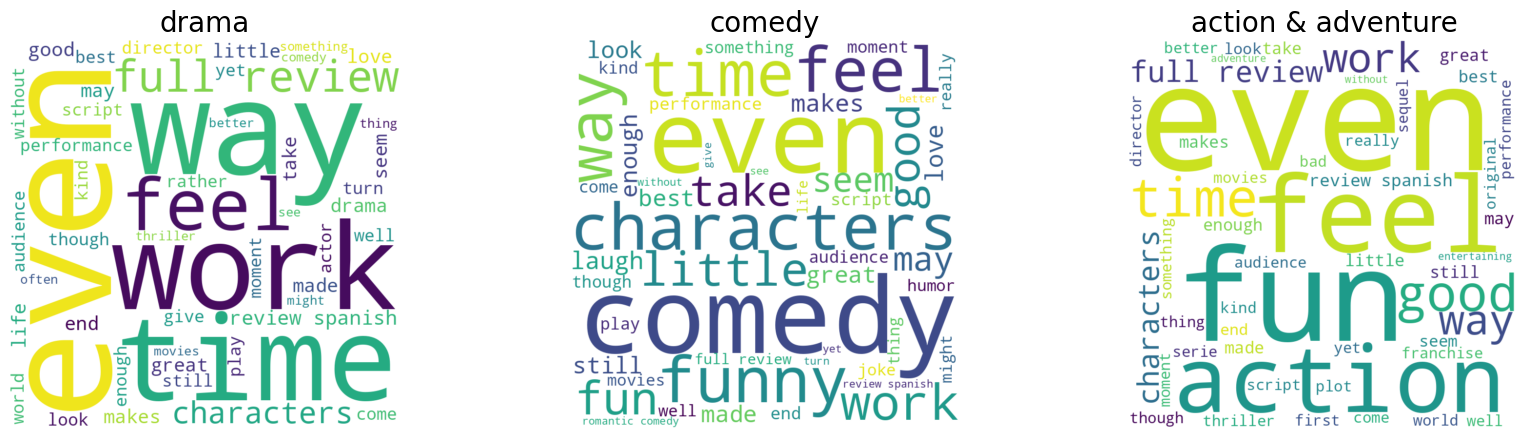

In [ ]:
plot_wordclouds(td_genre, ['drama', 'comedy', 'action & adventure'])

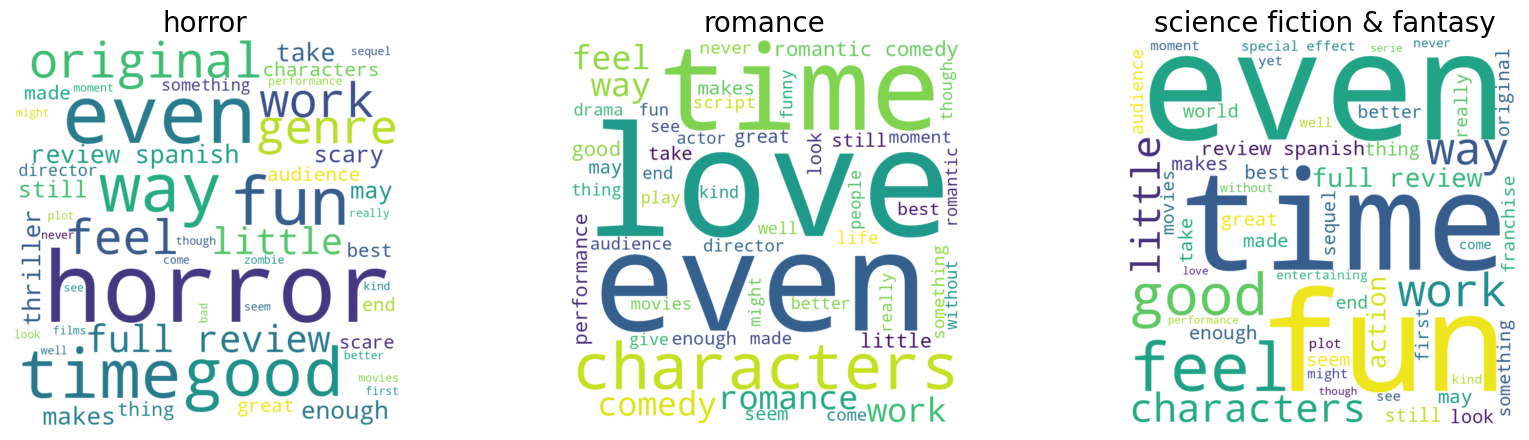

In [ ]:
plot_wordclouds(td_genre, ['horror', 'romance', 'science fiction & fantasy'])

#### Gender Results

In [ ]:
gender_results, td_gen = cal_tfidf('gender', 'review_content', num_top = 20)

In [ ]:
print(', '.join(gender_results['female']))
print(', '.join(gender_results['male']))

hard, children, main, else, takes, joy, insight, today, talented, strange, combination, ago, wasted, titular, teenage, leaves, disbelief, help, keeping, impressive
last, entertain, provides, making, approach, loud, soul, relationships, stories, os, superb, authentic, grand, superman, special, potential, superior, twist, wants, dramas


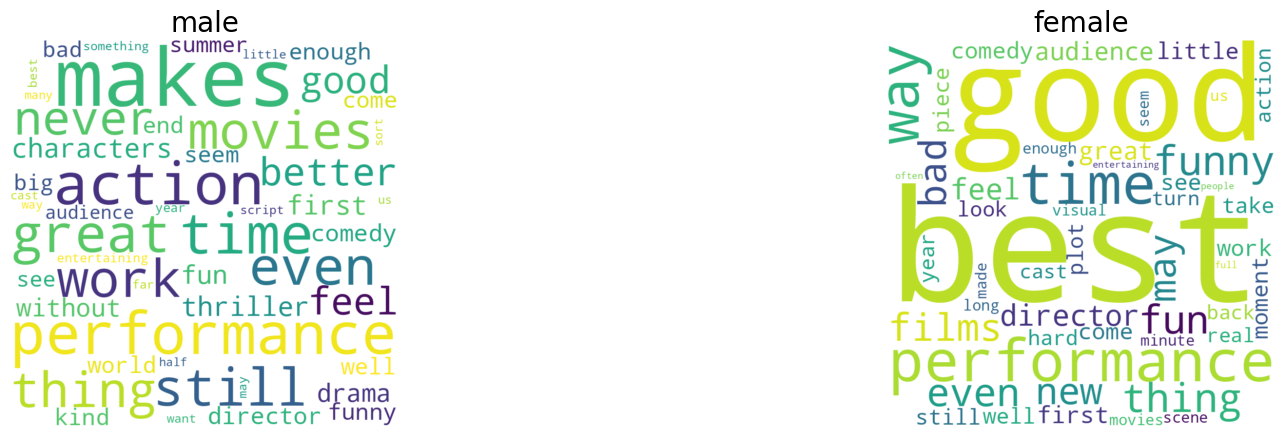

In [ ]:
plot_wordclouds(td_gen, ['male', 'female'])

#### Tomatometer Ratings

In [ ]:
test, td = cal_tfidf('tomatometer_rating', 'review_content', num_top = 20)

In [ ]:
print(', '.join(test['10-20']))
print(', '.join(test['30-40']))
print(', '.join(test['50-60']))
print(', '.join(test['60-70']))
print(', '.join(test['80-90']))
print(', '.join(test['90-100']))

allegiant, refueled, coopers, untraceable, turistas, aloha, firewall, eyez, wiesen, mooseport, madea, informers, peppermint, amelia, bye, eragon, geostorm, huntsman, miral, medallion
blackhat, chappie, grindelwald, wonderstone, dreamz, grimsby, zohan, reacher, marwen, nutcracker, inkheart, austenland, assange, internship, flightplan, blomkamp, crowne, poole, flyboys, windtalkers
southpaw, malek, leatherheads, rami, ninjago, adaline, guerin, highwaymen, mimzy, esq, lorax, artemis, pelham, nobbs, hesher, riddick, fela, bettie, benghazi, omalu
soldado, alita, pikachu, peregrine, mockingjay, hostiles, buzzsaw, wonderstruck, storks, chesil, xxl, guadagnino, secretariat, diviner, nureyev, elysium, westfeldt, atl, brüno, cosmopolis
shazam, reichardt, mcdonagh, fukunaga, hou, vol, shults, chazelle, julieta, parabellum, kiarostami, brigsby, blockers, okja, audiard, popes, chandor, homesman, deepwater, chbosky
farhadi, panahi, coogler, jia, anomalisa, granik, moana, zvyagintsev, chazelle, fruitv

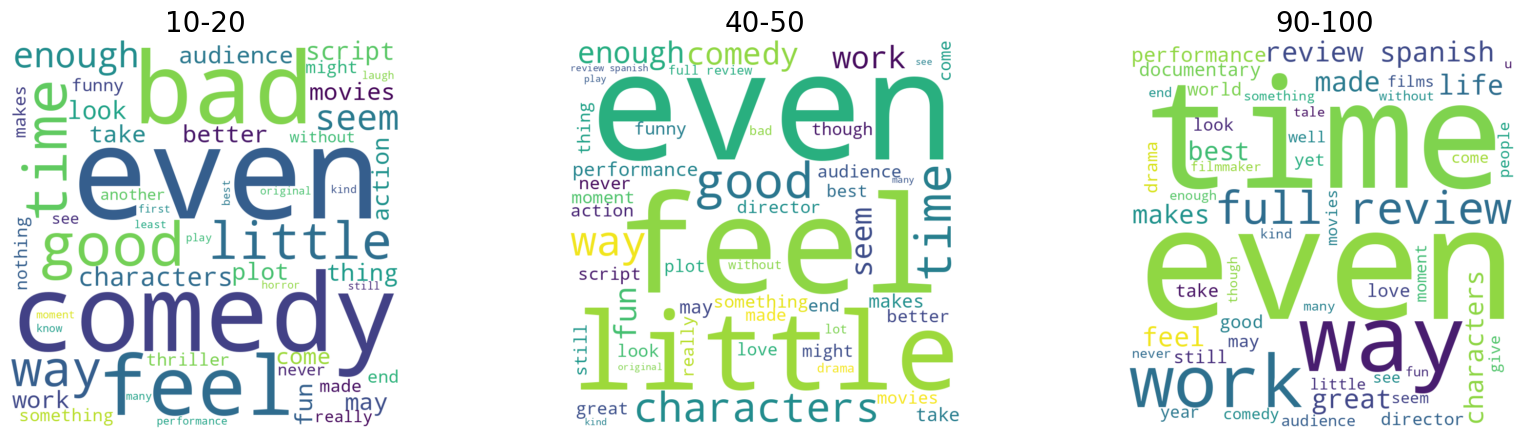

In [ ]:
plot_wordclouds(td, ['10-20', '40-50', '90-100'])

#### Audience Rating

In [ ]:
audience_results, td_aud = cal_tfidf('audience_rating', 'review_content', num_top = 20)

In [ ]:
print(', '.join(audience_results['10-20']))
print(', '.join(audience_results['30-40']))
print(', '.join(audience_results['50-60']))
print(', '.join(audience_results['60-70']))
print(', '.join(audience_results['80-90']))
print(', '.join(audience_results['90-100']))

hittman, mooseport, informers, feardotcom, lears, zoolander, dragonball, ecks, flanigan, cymbeline, canyons, aoc, snowman, kaos, pitof, xx, brest, luxx, mccanick, kazaam
vox, llorona, leatherheads, vivarium, wonderstone, buzzsaw, dreamz, lakeview, lux, sequel, nutcracker, corbet, coopers, macgruber, falcone, artemis, sanctum, happytime, jupiter, comic
covenant, unsane, blomkamp, peele, peregrine, valerian, sequel, genisys, american, homesman, chappie, grindelwald, comic, perfect, wonderstruck, adventure, bfg, summer, foulkes, beautiful
lanthimos, soldado, american, frankenweenie, jia, marling, widows, comic, biopic, guadagnino, rosewater, lowery, juneteenth, beautiful, perfect, smallfoot, sweet, sequel, book, colvin
shazam, american, moving, pixar, vol, beautiful, farhadi, moana, deepwater, blackkklansman, ragnarok, miyazaki, perfect, tonya, deadpool, biopic, coogler, musical, parabellum, malek
alita, miyazaki, capernaum, wilderpeople, baymax, coco, banksy, honnold, handmaiden, nolan, 

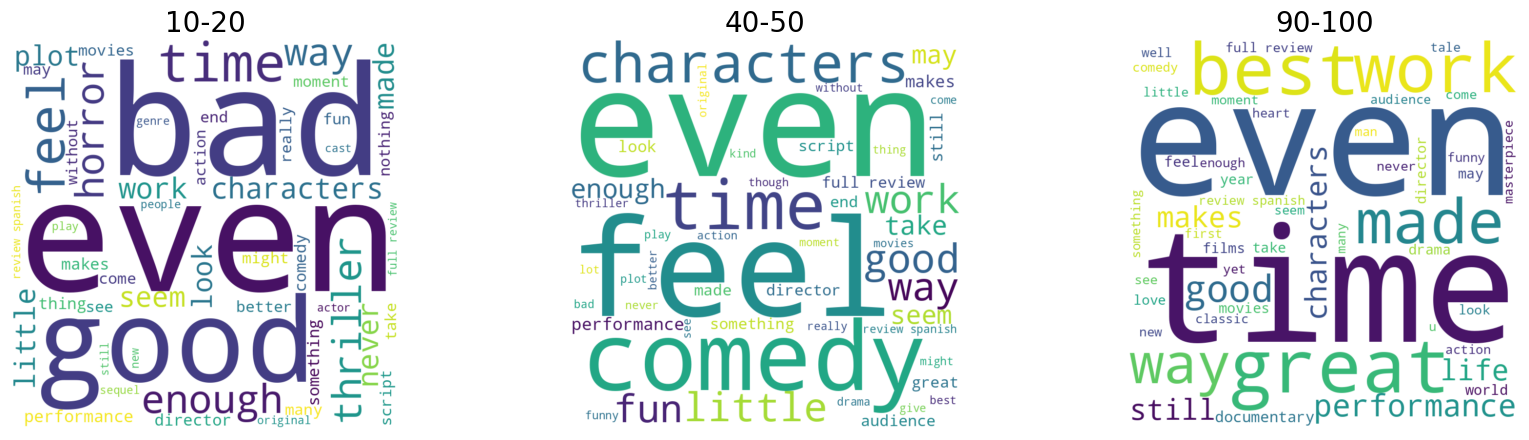

In [ ]:
plot_wordclouds(td_aud, ['10-20', '40-50', '90-100'])

## Network Text Analysis using WordClouds and TF-IDF statistics

In [ ]:
highest_tomato = pd.read_csv('movies_by_content_rating/highest_tomato.csv',header=None)
lowest_tomato = pd.read_csv('movies_by_content_rating/lowest_tomato.csv',header=None)
highest_audience = pd.read_csv('movies_by_content_rating/highest_audience.csv',header=None)
lowest_audience = pd.read_csv('movies_by_content_rating/lowest_audience.csv',header=None)

In [ ]:
highest_tomato_list = highest_tomato[0].to_list()
lowest_tomato_list = lowest_tomato[0].to_list()
highest_audience_list = highest_audience[0].to_list()
lowest_audience_list = lowest_audience[0].to_list()

In [ ]:
# Importing the 'rotten_tomatoes_critic_reviews' dataset
df_ = pd.read_csv('rotten_tomatoes_critic_reviews.csv')
df = df_.drop_duplicates()

# Importing the 'rotten_tomatoes_movies' dataset
pf = pd.read_csv('rotten_tomatoes_movies.csv')

In [ ]:
ht, td_ht = cal_tfidf('temp', 'review_content', num_top = 20, list_=highest_tomato_list)
lt, td_lt = cal_tfidf('temp', 'review_content', num_top = 20, list_=lowest_tomato_list)
ha, td_ha = cal_tfidf('temp', 'review_content', num_top = 20, list_=highest_audience_list)
la, td_la = cal_tfidf('temp', 'review_content', num_top = 20, list_=lowest_audience_list)

In [ ]:
print(', '.join(ht['temp']))
print(', '.join(lt['temp']))
print(', '.join(ha['temp']))
print(', '.join(la['temp']))

going, make, weepy, reason, ca, intelligence, insight, makers, sister, keeper, done, awkwardly, structured, warmly, emotional, relatively, unsentimental, drama, unsubtle, uneven
van, damme, tries, dispel, notion, ca, act, nothing, muscles, efforts, vain, exactly, looks, like, good, thing, see, psychological, complexity, social
serenely, powerful, handcrafted, film, navigates, place, martin, luther, king, called, tangled, discords, nation, required, viewing, citizens, especially, students, hope, repeat
van, damme, tries, dispel, notion, ca, act, nothing, muscles, efforts, vain, exactly, looks, like, good, thing, see, psychological, complexity, social


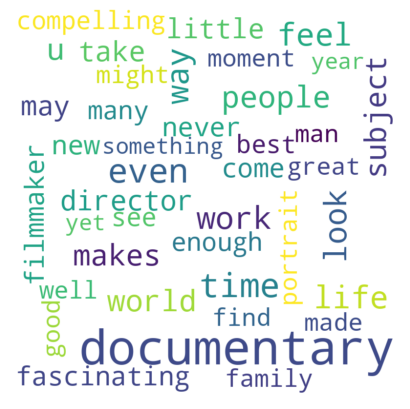

In [ ]:
plot_wordclouds(td_ht, ['temp'], 40, False)

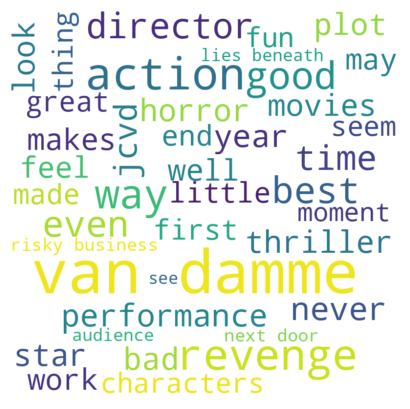

In [ ]:
plot_wordclouds(td_lt, ['temp'], 40, False)

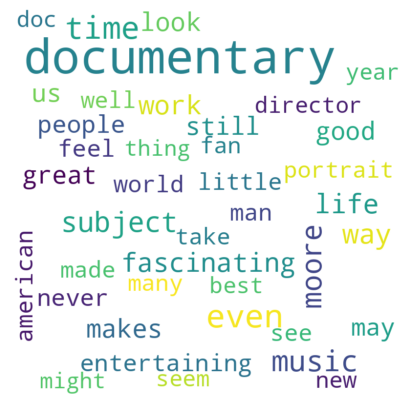

In [ ]:
plot_wordclouds(td_ha, ['temp'],40, False)

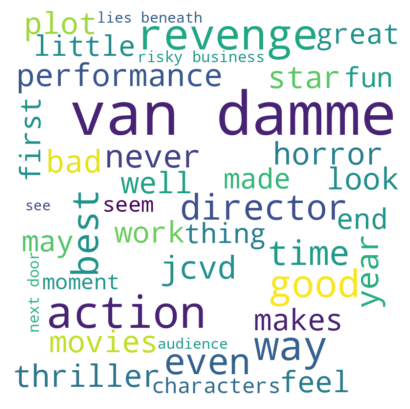

In [ ]:
plot_wordclouds(td_la, ['temp'], 40, False)

# Discussion

## Network Analysis
Some key points that could be added or also considered as part of the network analysis:

1. Modularity: Modularity could provide a strenght of division in the network, however without good comparison points it is quite intangible. It would only be useful if there were other divisions beside the Louvain division, maybe using different algorithms. The current ones (the genre and the rating) are clearly worse, and computing the modularity and comparing it wouldn't provide any useful information, as modularity is a relative measure and quite hard to grasp.

2. Better division: The modularity also leads to this point, it would be interesting to see if there are better division maybe covering the other features better. While compensating for the sample size differences this is really a half solution to the problem, but it is not clear how to determine an ideal community size, and if such division is possible. There are many routes to discover regarding this. Also probably to draw the best conclusions, the examination of both the original and the bi-graph at the same time would be necessary, since the multiple appearances of actors/movies could cause some misleading results.

## Text Analysis
Overall, we believe that our analysis of genres, actor's gender, and scores using TF-IDF analysis and word clouds was a good starting point for exploring the relationships. We effectively used both methods to extract important terms and generate visual representations of these terms, which provided some insights into the most common themes and opinions associated with different genres and scores.

However, there are a few areas where our analysis could be improved:

1. Further exploration of the data: While our analysis provided some useful insights, we could improve it by further exploring the data. For example, we could analyze the correlations between different terms and genres to identify which terms are most strongly associated with certain genres, or use statistical methods to identify patterns in the data that may not be immediately obvious.

2. Use of additional methods: While TF-IDF analysis and word clouds are useful tools for text analysis, they have some limitations and may not provide a complete picture of the data. To address this, we could use additional methods such as sentiment analysis, topic modeling, or network analysis to gain deeper insights into the data.

3. Interpretation of the results: While our analysis provided some interesting findings, it was somewhat lacking in terms of interpretation. To improve this, we could provide more detailed explanations of what the results mean and why they are important, as well as discuss potential implications of the findings for movie industry professionals, critics, and audiences.

In summary, while our analysis was a good starting point, it could be improved by further exploration of the data, use of additional methods, and more detailed interpretation of the results